In [64]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml


# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# Mapping bedrest to categorical variable
csdh['bedrest'] = csdh['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})

In [4]:
features = ['platelet', 'inr', 'stroke', 'antiplatelet', 'ihd', 'age', 'metalvalve', 
            'thickness_sum', 'membranes', 'optype', 'recurrence', 
            'drain', 'hospital', 'bedrest']
csdh = csdh[features]

In [5]:
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest']
for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [6]:
csdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   platelet       745 non-null    int64  
 1   inr            745 non-null    float64
 2   stroke         745 non-null    int8   
 3   antiplatelet   745 non-null    int8   
 4   ihd            745 non-null    int8   
 5   age            745 non-null    int64  
 6   metalvalve     745 non-null    int8   
 7   thickness_sum  745 non-null    int64  
 8   membranes      745 non-null    int8   
 9   optype         745 non-null    int8   
 10  recurrence     745 non-null    int8   
 11  drain          745 non-null    int8   
 12  hospital       745 non-null    int8   
 13  bedrest        745 non-null    int8   
dtypes: float64(1), int64(3), int8(10)
memory usage: 30.7 KB


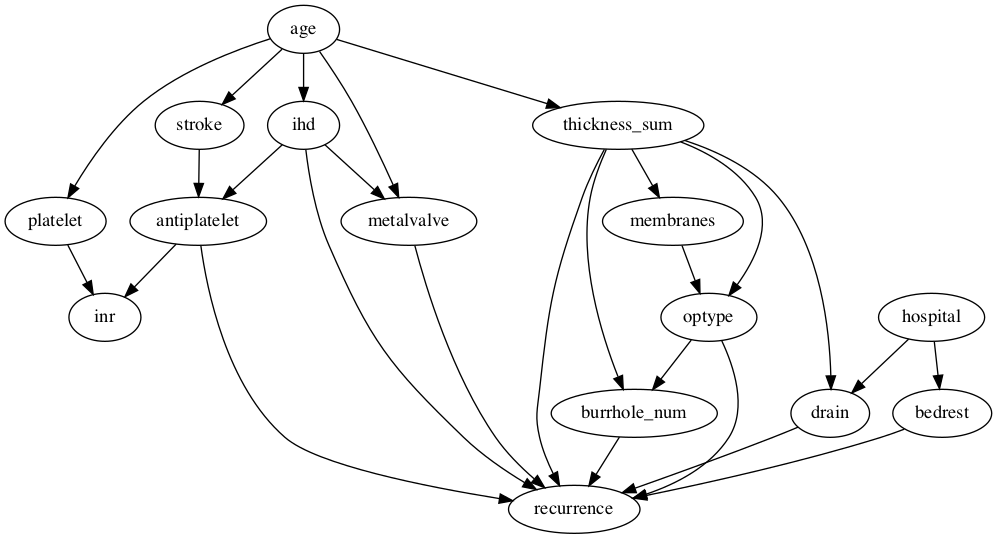

In [7]:
causal_model = CausalModel(data=csdh, 
                          treatment='drain', 
                          outcome='recurrence', 
                          graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "))
causal_model.view_model()
display(Image(filename="causal_model.png"))

In [8]:
csdh.head(10)

,platelet,inr,stroke,antiplatelet,ihd,age,metalvalve,thickness_sum,membranes,optype,recurrence,drain,hospital,bedrest
0,50,1.2,0,0,0,20,0,20,0,0,1,0,16,0
1,257,1.1,0,0,0,23,0,6,0,0,0,1,0,0
2,259,1.0,0,0,0,23,0,22,0,0,0,1,25,3
3,349,1.0,0,0,0,23,0,8,0,0,0,0,16,0
4,374,1.0,0,0,0,28,0,10,0,0,0,0,25,2
5,262,1.0,0,0,0,29,0,30,1,1,0,1,16,2
6,255,1.1,0,0,0,32,0,10,0,0,1,1,8,0
7,250,0.9,0,0,0,33,0,25,0,0,0,0,0,0
8,428,1.1,0,0,0,34,0,8,0,0,0,1,17,2
9,471,1.0,0,0,0,34,0,16,0,0,0,1,6,0


---
## Define set of classifiers to investigate

In [9]:
names = ['Dummy', 'MNB', 'GNB', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF']

In [10]:
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    MultinomialNB(),
    GaussianNB(),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(max_depth=7, n_estimators=40, random_state=random_state),
    RandomForestClassifier(max_depth=7, n_estimators=40, random_state=random_state)
]

## Predicting $Y$ (recurrence) from controls $X, W$

In [11]:
y_rec_full = csdh['recurrence']
X_rec_full = csdh.drop(['drain', 'recurrence'], axis=1)

In [12]:
# Split into validation set and rest
X_rec_rest, X_rec_val, y_rec_rest, y_rec_val = train_test_split(X_rec_full, y_rec_full, 
                                                                test_size=0.15,
                                                                random_state=random_state,
                                                                stratify=y_rec_full)

# Split rest into train and test set
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec_rest, y_rec_rest, 
                                                                    test_size=0.15,
                                                                    random_state=random_state,
                                                                    stratify=y_rec_rest)

In [13]:
rec_training_scores, rec_val_scores = mmh.train_and_validate_classifiers(X_rec_train, 
                                                                         y_rec_train,
                                                                         X_rec_val,
                                                                         y_rec_val,
                                                                         names,
                                                                         classifiers)

In [14]:
mmh.print_metrics_table(rec_training_scores, rec_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
MNB           0.875    0.480    0.000    0.000   4.317    0.894    0.556    0.140    0.197    3.659
GNB           0.884    0.530    0.100    0.133   4.009    0.883    0.558    0.160    0.203    4.045
LR            0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
Linear SVM    0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
RBF SVM       0.911    0.500    0.000    0.000   3.084    0.907    0.500    0.000    0.000    3.210
GB            0.893    0.490    0.000    0.000 

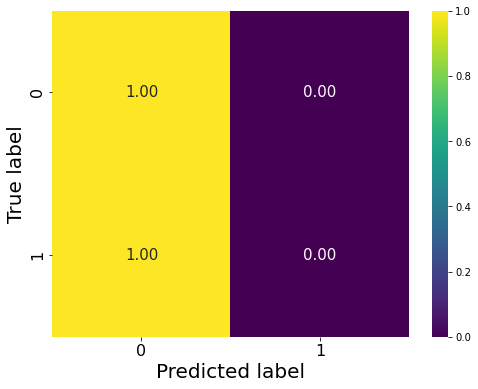

In [22]:
cm_rec_test = confusion_matrix(y_rec_test, classifiers[7].predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

---
## Predicting $T$ (drain) from controls $X, W$

In [23]:
y_drain_full = csdh['drain']
X_drain_full = csdh.drop(['drain', 'recurrence'], axis=1)

In [24]:
# Split into validation set and rest
X_drain_rest, X_drain_val, y_drain_rest, y_drain_val = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.15,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_test, y_drain_train, y_drain_test = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.15,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [25]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

In [26]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.839    0.500    1.000    0.913   5.551    0.835    0.500    1.000    0.910    5.714
MNB           0.768    0.637    0.830    0.857   8.018    0.712    0.584    0.775    0.818    9.951
GNB           0.830    0.607    0.936    0.903   5.859    0.783    0.599    0.873    0.870    7.511
LR            0.848    0.528    1.000    0.917   5.243    0.842    0.531    0.996    0.913    5.457
Linear SVM    0.839    0.500    1.000    0.913   5.551    0.835    0.500    1.000    0.910    5.714
RBF SVM       0.839    0.500    1.000    0.913   5.551    0.835    0.500    1.000    0.910    5.714
GB            0.857    0.600    0.979    0.920 

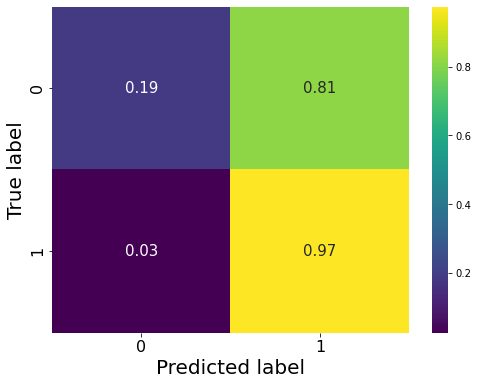

In [34]:
cm_drain_test = confusion_matrix(y_drain_test, classifiers[6].predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

---
## K-Fold cross validation for hyperparameter tuning and model selection

In [62]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [ ]:
# define classifiers and hyperparameters to search over
lr  = LogisticRegression()
params_lr = {
    'lr__solver':['newton-cg', 'lbfgs'],
    'lr__penalty':['none', 'l2'],
    'lr__C':loguniform(1e-5, 100)
}

svc = SVC()
params_svc = {'svc__kernel':['linear', 'rbf'],
              'svc__C':loguniform(10**(-5),10**2)}

rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    # minimum number of samples required to split an internal node
    'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':np.arange(0.6, 1.05, 0.05),
    # minimum number of samples required to split an internal node
    'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

In [ ]:
# define search spaces for random search tuning
search_space = [('lr', lr, params_lr), ('svc', svc, params_svc), 
                ('rf', rf, params_rf), ('gb', gb, params_gb)]

ensemble_search_space = [('rf', rf, params_rf), ('gb', gb, params_gb)]

In [282]:
class MyRandInt():
    """Wrapper class to return multivariate rand ints"""
    
    def __init__(self, low, high, dim):
        self.low = low
        self.high = high
        self.dim = dim
    
    def rvs(self, random_state=None):
        # increase proba to sample most complex config (hack, don't take too seriously)
        if stats.bernoulli.rvs(0.1):
            return np.full(self.dim, self.high, dtype=int)
        else:
            return stats.randint.rvs(self.low, self.high, size=(1, self.dim), random_state=random_state)[0]

In [301]:
np.mean(cross_val_score(Pipeline([('rf', RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2',
                                        min_samples_split=5,
                                        n_estimators=428, random_state=42))]), 
                X_drain_rest, 
                y_drain_rest, 
                cv=StratifiedKFold(n_splits=10, shuffle=True), 
                scoring='roc_auc', 
                n_jobs=-1))

In [283]:
def my_randomized_search_cv(X_train, y_train, search_space, n_iter=10,
                            cv=None, refit=True, verbose=False):
    """Maximises a cross-validation score by random search
    
    Parameters
    ------------
    Xtrain : nd array, (n_samples, n_features)
        Features used for training
    
    ytrain: nd array, (n_samples,)
        Labels used for training
        
    search_space: list
        Each element of the list must be a tuple (id, classifier_object, param_distributions)
        - id is a string
        - classifier_object is an instance of a classifier
        - param_distributions is a dictionary defining the search space of the hyperparameters,
          the entries can either be lists, or objects implementing a rvs() method returning a
          random sample.
          
    n_iter: int
        Number of trials in the random search
        
    cv: int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy, used with
        sklearn.model_selection.cross_val_score
        
    refit: bool
        Refit best estimator on the whole dataset
    
    verbose: bool
        Prints debug info
    
    Returns
    --------
    cv_scores: list
        list with cv scores
    
    configs: list
        list with sampled configurations
        
    best_estimator: 
        refitted estimator (if refit=True, else None is returned)
    
    """
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)                              

    if verbose:
        print("cv strategy", cv)
        
    # Number of classifiers
    L = len(search_space)
    
    # Random search
    cv_scores = []
    configs = []
    
    for trial in range(0, n_iter):
        
        if verbose:
            print("--"*20)
            print("Trial", trial)
            print("--"*20)
            
        # pick classifier
        index = np.random.choice(L)
        
        # sample a parameter configuration for the selected classifier   
        my_id = search_space[index][0]
        clf = search_space[index][1]
        param_distr = search_space[index][2]
        
        param_dict = {}
        for k, v in param_distr.items():
            if isinstance(v, list):
                param_dict[k] = np.random.choice(v)
            else:
                param_dict[k] = v.rvs()

        # construct pipeline
        pipe = Pipeline([(my_id, clf)])
        pipe.set_params(**param_dict)
        
        if verbose:
            print("Parameters", param_dict)
            print("Pipeline:", pipe)
            
        # compute cv score
        scores_tmp = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        
        if verbose:
            print("cv score:", scores_tmp)
                
        # store
        cv_scores.append(np.mean(scores_tmp))
        configs.append(pipe)
    
    if refit:
        print("--"*20)
        print("Selecting and refitting best classifier")
        print("--"*20)
        best_index = np.argmax(cv_scores)
        best_score = cv_scores[best_index]
        best_estimator = configs[best_index]
        best_estimator.fit(X_train, y_train)
        
        if verbose:
            print("best score:", best_score)
            print("best pipe:", best_estimator)
    else:
        best_estimator = None
        
    return cv_scores, configs, best_estimator

In [217]:
# do the search
_,_, best_estimator = my_randomized_search_cv(X_drain_full, y_drain_full, 
                                              search_space, 
                                              cv=StratifiedKFold(n_splits=5, shuffle=True),
                                              refit=True,
                                              n_iter=1000, 
                                              verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 299, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__min_samples_split': 0.2030670755424525, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            max_features='log2',
                                            min_samples_split=0.2030670755424525,
                                            n_estimators=299,
                                            random_state=42))])
cv score: [0.76935484 0.71870968 0.78677419 0.73833333 0.83633333]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'rf__n_estimators': 321, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__min_samples_split': 0.

cv score: [0.75258065 0.79387097 0.75064516 0.72166667 0.772     ]
----------------------------------------
Trial 19
----------------------------------------
Parameters {'lr__solver': 'lbfgs', 'lr__penalty': 'none', 'lr__C': 15.46032051187565}
Pipeline: Pipeline(steps=[('lr',
                 LogisticRegression(C=15.46032051187565, penalty='none'))])
cv score: [0.68032258 0.68645161 0.63548387 0.56633333 0.685     ]
----------------------------------------
Trial 20
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__min_samples_split': 0.053808986956346616, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7,
                                        min_samples_split=0.053808986956346616,
                                        n_estimators=188, random_state=42))])
cv score: [0.75935484 0.71935484 0.81129032 0.79466667 0.723     ]

cv score: [0.72048387 0.71645161 0.70064516 0.74783333 0.75666667]
----------------------------------------
Trial 36
----------------------------------------
Parameters {'gb__n_estimators': 219, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__min_samples_split': 0.07418564898370719, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                                            min_samples_split=0.07418564898370719,
                                            n_estimators=219,
                                            random_state=42))])
cv score: [0.7216129  0.68096774 0.60645161 0.759      0.73433333]
----------------------------------------
Trial 37
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 6.20983117525032e-05}
Pipeline: Pipeline(steps=[('svc', SVC(C=6.209831175

cv score: [0.74419355 0.78419355 0.70677419 0.807      0.83966667]
----------------------------------------
Trial 51
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__learning_rate': 3e-05, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__min_samples_split': 0.07979177506063878, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05,
                                            max_features='log2',
                                            min_samples_split=0.07979177506063878,
                                            n_estimators=105,
                                            random_state=42))])
cv score: [0.8266129  0.74387097 0.66596774 0.64183333 0.7755    ]
----------------------------------------
Trial 52
----------------------------------------
Parameters {'gb__n_estimators': 232, 'gb__learning_rate': 1e-05, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__min_samples

cv score: [0.60677419 0.61419355 0.78741935 0.59766667 0.69766667]
----------------------------------------
Trial 67
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__min_samples_split': 0.14194279905059487, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        min_samples_split=0.14194279905059487,
                                        n_estimators=71, random_state=42))])
cv score: [0.78129032 0.73903226 0.69483871 0.78666667 0.74666667]
----------------------------------------
Trial 68
----------------------------------------
Parameters {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 34.41223381296597}
Pipeline: Pipeline(steps=[('lr', LogisticRegression(C=34.41223381296597))])
cv score: [0.66483871 0.59451613 0.65741935 0.59633333 0.72266667]
-----------------

cv score: [0.73870968 0.80935484 0.80709677 0.71       0.76      ]
----------------------------------------
Trial 82
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 0.09040359898520617, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt',
                                        min_samples_split=0.09040359898520617,
                                        n_estimators=92, random_state=42))])
cv score: [0.70032258 0.77322581 0.76129032 0.82166667 0.779     ]
----------------------------------------
Trial 83
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__min_samples_split': 0.13227997932154195, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline

cv score: [0.77725806 0.78967742 0.72870968 0.7305     0.72983333]
----------------------------------------
Trial 99
----------------------------------------
Parameters {'gb__n_estimators': 403, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__min_samples_split': 0.11770740996646406, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='auto',
                                            min_samples_split=0.11770740996646406,
                                            n_estimators=403,
                                            random_state=42))])
cv score: [0.61774194 0.71225806 0.71709677 0.625      0.69633333]
----------------------------------------
Trial 100
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 0.16700461420704946}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.16700461420704946, ker

cv score: [0.79225806 0.75709677 0.75080645 0.82566667 0.657     ]
----------------------------------------
Trial 120
----------------------------------------
Parameters {'lr__solver': 'lbfgs', 'lr__penalty': 'none', 'lr__C': 64.58758598450616}
Pipeline: Pipeline(steps=[('lr',
                 LogisticRegression(C=64.58758598450616, penalty='none'))])
cv score: [0.74483871 0.65806452 0.55774194 0.762      0.62166667]
----------------------------------------
Trial 121
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__learning_rate': 0.003, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__min_samples_split': 0.05544043005014781, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=1,
                                            max_features='auto',
                                            min_samples_split=0.05544043005014781,
                                            n

cv score: [0.65774194 0.82612903 0.77064516 0.78366667 0.81166667]
----------------------------------------
Trial 137
----------------------------------------
Parameters {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 0.011905254527937364}
Pipeline: Pipeline(steps=[('lr', LogisticRegression(C=0.011905254527937364))])
cv score: [0.65290323 0.63645161 0.58225806 0.68433333 0.69833333]
----------------------------------------
Trial 138
----------------------------------------
Parameters {'rf__n_estimators': 309, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__min_samples_split': 0.13097060950983802, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_split=0.13097060950983802,
                                        n_estimators=309, random_state=42))])
cv score: [0.74177419 0.82370968 0.77629032 0.77933333 0.75033333]
-----------

cv score: [0.76967742 0.76290323 0.78290323 0.73066667 0.74833333]
----------------------------------------
Trial 155
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_split': 0.13629798944051003, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        min_samples_split=0.13629798944051003,
                                        n_estimators=145, random_state=42))])
cv score: [0.77225806 0.69064516 0.79870968 0.72333333 0.854     ]
----------------------------------------
Trial 156
----------------------------------------
Parameters {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 0.1110619052665912}
Pipeline: Pipeline(steps=[('lr', LogisticRegression(C=0.1110619052665912))])
cv score: [0.66806452 0.62806452 0.65322581 0.663      0.708     ]
-----------

Parameters {'svc__kernel': 'rbf', 'svc__C': 0.00037486999867377844}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.00037486999867377844))])
cv score: [0.59870968 0.52096774 0.56129032 0.61633333 0.56133333]
----------------------------------------
Trial 174
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 0.39533839484460725}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.39533839484460725, kernel='linear'))])
cv score: [0.66322581 0.56741935 0.79580645 0.59866667 0.639     ]
----------------------------------------
Trial 175
----------------------------------------
Parameters {'svc__kernel': 'rbf', 'svc__C': 0.13706130527790314}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.13706130527790314))])
cv score: [0.61387097 0.51419355 0.45935484 0.635      0.48233333]
----------------------------------------
Trial 176
----------------------------------------
Parameters {'svc__kernel': 'rbf', 'svc__C': 63.37064778003591}
Pipeline: Pipeline(steps=[('svc', SVC(C=63.3706

cv score: [0.62645161 0.65741935 0.64870968 0.572      0.60133333]
----------------------------------------
Trial 193
----------------------------------------
Parameters {'lr__solver': 'newton-cg', 'lr__penalty': 'l2', 'lr__C': 1.5662055761961736e-05}
Pipeline: Pipeline(steps=[('lr',
                 LogisticRegression(C=1.5662055761961736e-05,
                                    solver='newton-cg'))])
cv score: [0.4983871  0.6383871  0.55129032 0.61833333 0.61733333]
----------------------------------------
Trial 194
----------------------------------------
Parameters {'rf__n_estimators': 399, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 0.10620618673536555, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt',
                                        min_samples_split=0.10620618673536555,
             

cv score: [0.78806452 0.7316129  0.72548387 0.775      0.82866667]
----------------------------------------
Trial 215
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__min_samples_split': 0.13865413449760483, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=9,
                                            min_samples_split=0.13865413449760483,
                                            n_estimators=17,
                                            random_state=42))])
cv score: [0.785      0.795      0.79225806 0.69916667 0.819     ]
----------------------------------------
Trial 216
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 0.2914341922586884}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.2914341922586884, kernel='linear'))])
cv score: [0.64419355 0.54903226 0.6

KeyboardInterrupt: 

In [285]:
# do the search
_,_, e_best_estimator = my_randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                ensemble_search_space, 
                                                cv=StratifiedKFold(n_splits=5, shuffle=True),
                                                refit=True,
                                                n_iter=5000, 
                                                verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'rf__n_estimators': 358, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        n_estimators=358, random_state=42))])
cv score: [0.7401168  0.74797844 0.77628032 0.73106576 0.7170068 ]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'rf__n_estimators': 286, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=286,
                                        random_stat

cv score: [0.77897574 0.79065588 0.7214735  0.77460317 0.83900227]
----------------------------------------
Trial 16
----------------------------------------
Parameters {'gb__n_estimators': 213, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=213,
                                            random_state=42))])
cv score: [0.79424978 0.74123989 0.69047619 0.71791383 0.65442177]
----------------------------------------
Trial 17
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__learning_rate': 0.0001, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=1,
                                            max_features='auto',
                                            n_estimators=181,
  

cv score: [0.80637916 0.74730458 0.76055705 0.7723356  0.74557823]
----------------------------------------
Trial 32
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=115,
                                        random_state=42))])
cv score: [0.73315364 0.54694519 0.74618149 0.75079365 0.7292517 ]
----------------------------------------
Trial 33
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='auto',
                                            n_estimators=52,
                    

cv score: [0.78077269 0.7574124  0.73629829 0.76235828 0.77414966]
----------------------------------------
Trial 48
----------------------------------------
Parameters {'gb__n_estimators': 344, 'gb__learning_rate': 1e-05, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=1,
                                            n_estimators=344,
                                            random_state=42))])
cv score: [0.53369272 0.5098832  0.55256065 0.51904762 0.54285714]
----------------------------------------
Trial 49
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=177,
 

cv score: [0.73045822 0.63836478 0.57187781 0.63310658 0.49160998]
----------------------------------------
Trial 64
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=139, random_state=42))])
cv score: [0.64016173 0.80548068 0.76145553 0.73922902 0.81405896]
----------------------------------------
Trial 65
----------------------------------------
Parameters {'rf__n_estimators': 278, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=278, random_state=42))])
cv score: [0.83647799 0.79380054 0.78256963 0.81315193 0.7

cv score: [0.82255166 0.66082659 0.59973046 0.6739229  0.59909297]
----------------------------------------
Trial 81
----------------------------------------
Parameters {'rf__n_estimators': 282, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=282, random_state=42))])
cv score: [0.82884097 0.7648248  0.70035939 0.78390023 0.76235828]
----------------------------------------
Trial 82
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=119,
                                        random_state=42))])


cv score: [0.53391734 0.43126685 0.31109614 0.44285714 0.61995465]
----------------------------------------
Trial 97
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            n_estimators=137,
                                            random_state=42))])
cv score: [0.62938005 0.76415094 0.80368374 0.57868481 0.60770975]
----------------------------------------
Trial 98
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__learning_rate': 3.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=6,
                                            max_features='log2',
        

cv score: [0.72641509 0.75651393 0.62690925 0.71088435 0.661678  ]
----------------------------------------
Trial 114
----------------------------------------
Parameters {'rf__n_estimators': 233, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, n_estimators=233,
                                        random_state=42))])
cv score: [0.72911051 0.7425876  0.68418688 0.72199546 0.83310658]
----------------------------------------
Trial 115
----------------------------------------
Parameters {'gb__n_estimators': 204, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='log2',
                                            n_estimators=204,
           

cv score: [0.72192273 0.73225517 0.66127583 0.85759637 0.77188209]
----------------------------------------
Trial 130
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=76,
                                            random_state=42))])
cv score: [0.82614555 0.7933513  0.70619946 0.7845805  0.78367347]
----------------------------------------
Trial 131
----------------------------------------
Parameters {'gb__n_estimators': 374, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=374,
    

cv score: [0.76010782 0.74528302 0.78167116 0.75102041 0.68752834]
----------------------------------------
Trial 147
----------------------------------------
Parameters {'gb__n_estimators': 292, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                                            n_estimators=292,
                                            random_state=42))])
cv score: [0.67340521 0.69811321 0.56603774 0.78231293 0.77687075]
----------------------------------------
Trial 148
----------------------------------------
Parameters {'rf__n_estimators': 342, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features=None,
                                        n_estimators=342, random_state=42))

cv score: [0.69856244 0.72506739 0.81356694 0.69478458 0.80226757]
----------------------------------------
Trial 164
----------------------------------------
Parameters {'gb__n_estimators': 376, 'gb__learning_rate': 0.0001, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001,
                                            max_features='auto',
                                            n_estimators=376,
                                            random_state=42))])
cv score: [0.62713387 0.50089847 0.60175202 0.55351474 0.55759637]
----------------------------------------
Trial 165
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__learning_rate': 0.0001, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=2,
     

cv score: [0.74550764 0.74707996 0.68373765 0.7324263  0.69478458]
----------------------------------------
Trial 179
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=97, random_state=42))])
cv score: [0.77628032 0.81716083 0.8539982  0.7292517  0.80090703]
----------------------------------------
Trial 180
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__learning_rate': 1e-05, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=6,
                                            n_estimators=14,
                                            random_state=42))])
c

cv score: [0.79200359 0.78796047 0.76010782 0.78548753 0.79319728]
----------------------------------------
Trial 195
----------------------------------------
Parameters {'rf__n_estimators': 339, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        n_estimators=339, random_state=42))])
cv score: [0.7982929  0.81491465 0.6769991  0.7755102  0.82403628]
----------------------------------------
Trial 196
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=15

cv score: [0.82973944 0.81356694 0.75022462 0.8122449  0.76190476]
----------------------------------------
Trial 211
----------------------------------------
Parameters {'gb__n_estimators': 50, 'gb__learning_rate': 3.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=50,
                                            random_state=42))])
cv score: [0.49640611 0.58018868 0.60377358 0.48752834 0.4047619 ]
----------------------------------------
Trial 212
----------------------------------------
Parameters {'rf__n_estimators': 390, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
          

cv score: [0.77380952 0.81985624 0.72394429 0.80090703 0.79183673]
----------------------------------------
Trial 227
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=155, random_state=42))])
cv score: [0.75786164 0.74977538 0.79559748 0.77913832 0.7414966 ]
----------------------------------------
Trial 228
----------------------------------------
Parameters {'rf__n_estimators': 224, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=224,
                                        random_state=4

cv score: [0.59299191 0.67385445 0.69496855 0.60634921 0.6399093 ]
----------------------------------------
Trial 243
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=105,
                                        random_state=42))])
cv score: [0.76999102 0.78256963 0.71114106 0.76961451 0.75056689]
----------------------------------------
Trial 244
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__learning_rate': 0.0001, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=7,
                                            max_features='

cv score: [0.81132075 0.75157233 0.72416891 0.79365079 0.69251701]
----------------------------------------
Trial 259
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        n_estimators=128, random_state=42))])
cv score: [0.74281222 0.84815813 0.67115903 0.7537415  0.7122449 ]
----------------------------------------
Trial 260
----------------------------------------
Parameters {'rf__n_estimators': 339, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=339,
                                        random_state=42))

cv score: [0.73495058 0.78077269 0.69788859 0.67505669 0.75736961]
----------------------------------------
Trial 274
----------------------------------------
Parameters {'rf__n_estimators': 406, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=406, random_state=42))])
cv score: [0.76684636 0.76774483 0.71563342 0.77959184 0.79863946]
----------------------------------------
Trial 275
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=26,
                                            random_state=42))])
cv 

cv score: [0.7327044  0.6572327  0.66801438 0.75510204 0.74557823]
----------------------------------------
Trial 290
----------------------------------------
Parameters {'gb__n_estimators': 407, 'gb__learning_rate': 3e-05, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=1,
                                            max_features='log2',
                                            n_estimators=407,
                                            random_state=42))])
cv score: [0.59883199 0.64083558 0.67902066 0.61428571 0.62585034]
----------------------------------------
Trial 291
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=1,


cv score: [0.70754717 0.72237197 0.83692722 0.8        0.67664399]
----------------------------------------
Trial 308
----------------------------------------
Parameters {'rf__n_estimators': 251, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=251, random_state=42))])
cv score: [0.71383648 0.74977538 0.67430368 0.83673469 0.85260771]
----------------------------------------
Trial 309
----------------------------------------
Parameters {'gb__n_estimators': 442, 'gb__learning_rate': 3e-05, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=4,
                                            max_features='log2',
                                            n_estima

cv score: [0.68418688 0.79739443 0.78571429 0.74693878 0.66984127]
----------------------------------------
Trial 324
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=185,
                                            random_state=42))])
cv score: [0.78751123 0.76909254 0.65902965 0.81133787 0.74739229]
----------------------------------------
Trial 325
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
     

cv score: [0.40880503 0.62174304 0.5965858  0.63786848 0.41587302]
----------------------------------------
Trial 341
----------------------------------------
Parameters {'rf__n_estimators': 466, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=466,
                                        random_state=42))])
cv score: [0.77538185 0.69901168 0.80480683 0.8244898  0.67732426]
----------------------------------------
Trial 342
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=166, random_state=4

cv score: [0.82165319 0.81042228 0.74438455 0.70975057 0.77868481]
----------------------------------------
Trial 358
----------------------------------------
Parameters {'gb__n_estimators': 240, 'gb__learning_rate': 0.0003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=9,
                                            max_features='log2',
                                            n_estimators=240,
                                            random_state=42))])
cv score: [0.73135669 0.71967655 0.76999102 0.79954649 0.78412698]
----------------------------------------
Trial 359
----------------------------------------
Parameters {'gb__n_estimators': 408, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators

cv score: [0.68014376 0.74618149 0.86522911 0.78548753 0.72743764]
----------------------------------------
Trial 374
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=162,
                                        random_state=42))])
cv score: [0.76774483 0.69092543 0.75876011 0.77913832 0.8276644 ]
----------------------------------------
Trial 375
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=141, random_sta

cv score: [0.69294699 0.67587601 0.68328841 0.65918367 0.7047619 ]
----------------------------------------
Trial 390
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                            n_estimators=22,
                                            random_state=42))])
cv score: [0.68328841 0.73629829 0.70799641 0.78185941 0.6984127 ]
----------------------------------------
Trial 391
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
               

cv score: [0.69856244 0.7821204  0.66486972 0.79727891 0.77188209]
----------------------------------------
Trial 407
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=119,
                                            random_state=42))])
cv score: [0.80548068 0.75786164 0.75920934 0.70702948 0.75328798]
----------------------------------------
Trial 408
----------------------------------------
Parameters {'rf__n_estimators': 390, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=390,
                                        random_state=42))])
cv score: [0.7

cv score: [0.73068284 0.64420485 0.5172956  0.66825397 0.61768707]
----------------------------------------
Trial 424
----------------------------------------
Parameters {'gb__n_estimators': 483, 'gb__learning_rate': 0.0001, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=5,
                                            max_features='auto',
                                            n_estimators=483,
                                            random_state=42))])
cv score: [0.75516622 0.76707098 0.71114106 0.83106576 0.70839002]
----------------------------------------
Trial 425
----------------------------------------
Parameters {'gb__n_estimators': 306, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_

cv score: [0.73180593 0.74797844 0.82030548 0.79546485 0.74557823]
----------------------------------------
Trial 441
----------------------------------------
Parameters {'rf__n_estimators': 363, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=363,
                                        random_state=42))])
cv score: [0.73382749 0.54537287 0.69946092 0.53900227 0.68253968]
----------------------------------------
Trial 442
----------------------------------------
Parameters {'rf__n_estimators': 363, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        n_estimators=363, random_state=42))

cv score: [0.59838275 0.62668464 0.63095238 0.6414966  0.6739229 ]
----------------------------------------
Trial 457
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='log2', n_estimators=116,
                                        random_state=42))])
cv score: [0.75786164 0.63948787 0.57592093 0.78163265 0.72562358]
----------------------------------------
Trial 458
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='sqrt',

cv score: [0.80637916 0.80098832 0.73674753 0.76281179 0.83582766]
----------------------------------------
Trial 473
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='log2', n_estimators=45,
                                        random_state=42))])
cv score: [0.64487871 0.65633423 0.59613657 0.72108844 0.72789116]
----------------------------------------
Trial 474
----------------------------------------
Parameters {'gb__n_estimators': 238, 'gb__learning_rate': 3.0, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=2,
                                            max_features='auto',


cv score: [0.84681042 0.72731357 0.81042228 0.75510204 0.64807256]
----------------------------------------
Trial 489
----------------------------------------
Parameters {'gb__n_estimators': 247, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            n_estimators=247,
                                            random_state=42))])
cv score: [0.64240791 0.68508535 0.77920036 0.63424036 0.7031746 ]
----------------------------------------
Trial 490
----------------------------------------
Parameters {'gb__n_estimators': 477, 'gb__learning_rate': 0.0001, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=8,
                                            max_features='au

cv score: [0.57479784 0.53054807 0.59231806 0.60453515 0.34421769]
----------------------------------------
Trial 505
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='auto',
                                            n_estimators=99,
                                            random_state=42))])
cv score: [0.65408805 0.57322552 0.79604672 0.60408163 0.71746032]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'gb__n_estimators': 290, 'gb__learning_rate': 3.0, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=2,
     

cv score: [0.60197664 0.80098832 0.72192273 0.70702948 0.72244898]
----------------------------------------
Trial 520
----------------------------------------
Parameters {'rf__n_estimators': 330, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
                                        n_estimators=330, random_state=42))])
cv score: [0.66846361 0.69047619 0.7821204  0.79138322 0.55827664]
----------------------------------------
Trial 521
----------------------------------------
Parameters {'gb__n_estimators': 439, 'gb__learning_rate': 1e-05, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=7,
                                            max_features='sqrt',
                                            n_estima

cv score: [0.86073675 0.82210243 0.71203953 0.77188209 0.82222222]
----------------------------------------
Trial 536
----------------------------------------
Parameters {'gb__n_estimators': 305, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            n_estimators=305,
                                            random_state=42))])
cv score: [0.80772686 0.7524708  0.6918239  0.73151927 0.7845805 ]
----------------------------------------
Trial 537
----------------------------------------
Parameters {'gb__n_estimators': 375, 'gb__learning_rate': 0.0001, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=1,
                                            max_features='auto

cv score: [0.76280323 0.79964061 0.81446541 0.65079365 0.78548753]
----------------------------------------
Trial 553
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__learning_rate': 0.001, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=48,
                                            random_state=42))])
cv score: [0.6671159  0.65633423 0.68530997 0.69501134 0.63560091]
----------------------------------------
Trial 554
----------------------------------------
Parameters {'gb__n_estimators': 422, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
 

cv score: [0.77088949 0.8081761  0.73944295 0.74512472 0.73650794]
----------------------------------------
Trial 570
----------------------------------------
Parameters {'rf__n_estimators': 370, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=370,
                                        random_state=42))])
cv score: [0.67385445 0.82929021 0.73495058 0.78594104 0.71519274]
----------------------------------------
Trial 571
----------------------------------------
Parameters {'rf__n_estimators': 307, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=307, random_sta

cv score: [0.77313567 0.7165319  0.66037736 0.7446712  0.75283447]
----------------------------------------
Trial 585
----------------------------------------
Parameters {'rf__n_estimators': 348, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=348, random_state=42))])
cv score: [0.74977538 0.80682839 0.78481581 0.73514739 0.75283447]
----------------------------------------
Trial 586
----------------------------------------
Parameters {'gb__n_estimators': 326, 'gb__learning_rate': 3.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators

cv score: [0.71540881 0.82479784 0.79200359 0.72335601 0.69614512]
----------------------------------------
Trial 602
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=131,
                                            random_state=42))])
cv score: [0.74079066 0.76010782 0.68800539 0.80725624 0.71247166]
----------------------------------------
Trial 603
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__learning_rate': 0.0001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_de

cv score: [0.82255166 0.80053908 0.74618149 0.77460317 0.73922902]
----------------------------------------
Trial 618
----------------------------------------
Parameters {'gb__n_estimators': 195, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='log2',
                                            n_estimators=195,
                                            random_state=42))])
cv score: [0.74977538 0.81266846 0.77762803 0.75192744 0.76870748]
----------------------------------------
Trial 619
----------------------------------------
Parameters {'gb__n_estimators': 487, 'gb__learning_rate': 3e-05, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=

cv score: [0.7178796  0.77672956 0.81940701 0.74739229 0.75873016]
----------------------------------------
Trial 633
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        n_estimators=185, random_state=42))])
cv score: [0.73225517 0.63926325 0.76078167 0.71428571 0.74421769]
----------------------------------------
Trial 634
----------------------------------------
Parameters {'gb__n_estimators': 226, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            n_estimators=226,
                                            random_state=42))])


cv score: [0.86163522 0.7771788  0.7214735  0.79047619 0.76371882]
----------------------------------------
Trial 650
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=72,
                                            random_state=42))])
cv score: [0.78930818 0.79065588 0.75202156 0.73061224 0.72698413]
----------------------------------------
Trial 651
----------------------------------------
Parameters {'gb__n_estimators': 463, 'gb__learning_rate': 1.0, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
     

cv score: [0.79964061 0.8328841  0.67565139 0.7968254  0.83129252]
----------------------------------------
Trial 666
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='log2',
                                            n_estimators=188,
                                            random_state=42))])
cv score: [0.81536388 0.72911051 0.68104223 0.78594104 0.67981859]
----------------------------------------
Trial 667
----------------------------------------
Parameters {'gb__n_estimators': 387, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='auto',
            

cv score: [0.87151842 0.76549865 0.79424978 0.7414966  0.76145125]
----------------------------------------
Trial 681
----------------------------------------
Parameters {'rf__n_estimators': 266, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=266, random_state=42))])
cv score: [0.7475292  0.7277628  0.7982929  0.83174603 0.72970522]
----------------------------------------
Trial 682
----------------------------------------
Parameters {'rf__n_estimators': 345, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        n_estimators=345, random_state=42))])
cv score: [0.68171608 0.56491465 0.61567835 0.68662

cv score: [0.64577718 0.7327044  0.69788859 0.72040816 0.71179138]
----------------------------------------
Trial 697
----------------------------------------
Parameters {'rf__n_estimators': 315, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=315,
                                        random_state=42))])
cv score: [0.71091644 0.75089847 0.57659479 0.72267574 0.80430839]
----------------------------------------
Trial 698
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        n_estimators=130, random_state=42))

cv score: [0.6336478  0.75224618 0.67093441 0.87369615 0.77981859]
----------------------------------------
Trial 713
----------------------------------------
Parameters {'rf__n_estimators': 298, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=298, random_state=42))])
cv score: [0.74079066 0.75965858 0.71024259 0.76780045 0.79183673]
----------------------------------------
Trial 714
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__learning_rate': 3.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0,
                                            max_features='sqrt',
                                            n_estimators=42,
         

cv score: [0.77313567 0.7475292  0.82165319 0.77052154 0.73922902]
----------------------------------------
Trial 728
----------------------------------------
Parameters {'rf__n_estimators': 424, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=424,
                                        random_state=42))])
cv score: [0.70260557 0.60377358 0.80884996 0.7138322  0.77210884]
----------------------------------------
Trial 729
----------------------------------------
Parameters {'rf__n_estimators': 335, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=335,
                                        random_state=42))])
cv score: [0.73

cv score: [0.72259659 0.7066487  0.81895777 0.68163265 0.75510204]
----------------------------------------
Trial 743
----------------------------------------
Parameters {'rf__n_estimators': 421, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=421, random_state=42))])
cv score: [0.75202156 0.83198562 0.78167116 0.7015873  0.76281179]
----------------------------------------
Trial 744
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=73, random_state=42))])
cv score: [0.82120395 0.8230009  0.80974843 0.76530612

cv score: [0.79020665 0.81132075 0.79110512 0.71564626 0.77188209]
----------------------------------------
Trial 760
----------------------------------------
Parameters {'gb__n_estimators': 434, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            n_estimators=434,
                                            random_state=42))])
cv score: [0.67744834 0.68418688 0.62309075 0.61405896 0.6739229 ]
----------------------------------------
Trial 761
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, n_estimators=108,
                                        random_state=42))])
cv score: [0.80098

cv score: [0.61410602 0.80862534 0.63207547 0.68208617 0.70748299]
----------------------------------------
Trial 776
----------------------------------------
Parameters {'gb__n_estimators': 271, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            max_features='auto',
                                            n_estimators=271,
                                            random_state=42))])
cv score: [0.762354   0.59613657 0.67924528 0.5814059  0.64081633]
----------------------------------------
Trial 777
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
              

cv score: [0.73629829 0.76909254 0.68104223 0.72517007 0.73378685]
----------------------------------------
Trial 792
----------------------------------------
Parameters {'rf__n_estimators': 425, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=425,
                                        random_state=42))])
cv score: [0.71361186 0.74573226 0.65521114 0.59727891 0.82335601]
----------------------------------------
Trial 793
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=159, random_sta

cv score: [0.41239892 0.48989218 0.58400719 0.630839   0.35827664]
----------------------------------------
Trial 808
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=75,
                                        random_state=42))])
cv score: [0.85130279 0.7524708  0.75920934 0.65578231 0.78276644]
----------------------------------------
Trial 809
----------------------------------------
Parameters {'gb__n_estimators': 223, 'gb__learning_rate': 3e-05, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05,
                                            n_estimators=223,
              

cv score: [0.73135669 0.76954178 0.77807727 0.76689342 0.82267574]
----------------------------------------
Trial 824
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__learning_rate': 0.0003, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=2,
                                            n_estimators=86,
                                            random_state=42))])
cv score: [0.52111411 0.60354897 0.62780773 0.68027211 0.59569161]
----------------------------------------
Trial 825
----------------------------------------
Parameters {'gb__n_estimators': 452, 'gb__learning_rate': 3e-05, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=4,
                                            max_features='log2

cv score: [0.57726864 0.56491465 0.57996406 0.35827664 0.48639456]
----------------------------------------
Trial 841
----------------------------------------
Parameters {'gb__n_estimators': 448, 'gb__learning_rate': 3.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=448,
                                            random_state=42))])
cv score: [0.63903863 0.45844564 0.60287511 0.57414966 0.64195011]
----------------------------------------
Trial 842
----------------------------------------
Parameters {'gb__n_estimators': 435, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
   

cv score: [0.78391734 0.74438455 0.65813118 0.75079365 0.81360544]
----------------------------------------
Trial 858
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=93,
                                            random_state=42))])
cv score: [0.72057502 0.79155436 0.71967655 0.70521542 0.67981859]
----------------------------------------
Trial 859
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=84,
               

cv score: [0.68957772 0.87556155 0.69496855 0.79863946 0.81814059]
----------------------------------------
Trial 875
----------------------------------------
Parameters {'gb__n_estimators': 354, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='auto',
                                            n_estimators=354,
                                            random_state=42))])
cv score: [0.74348607 0.78436658 0.74393531 0.72380952 0.66031746]
----------------------------------------
Trial 876
----------------------------------------
Parameters {'gb__n_estimators': 255, 'gb__learning_rate': 0.0001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_dept

cv score: [0.82389937 0.70035939 0.82659479 0.77868481 0.72834467]
----------------------------------------
Trial 893
----------------------------------------
Parameters {'rf__n_estimators': 390, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=390,
                                        random_state=42))])
cv score: [0.75067385 0.83557951 0.71743037 0.79909297 0.75873016]
----------------------------------------
Trial 894
----------------------------------------
Parameters {'gb__n_estimators': 358, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='l

cv score: [0.76819407 0.71967655 0.80368374 0.80589569 0.78594104]
----------------------------------------
Trial 908
----------------------------------------
Parameters {'gb__n_estimators': 434, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            max_features='auto',
                                            n_estimators=434,
                                            random_state=42))])
cv score: [0.76325247 0.68149146 0.81536388 0.77437642 0.80770975]
----------------------------------------
Trial 909
----------------------------------------
Parameters {'rf__n_estimators': 407, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
  

cv score: [0.71990117 0.84119497 0.55098832 0.57324263 0.76984127]
----------------------------------------
Trial 925
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, n_estimators=170,
                                        random_state=42))])
cv score: [0.56716083 0.74573226 0.77380952 0.75328798 0.70929705]
----------------------------------------
Trial 926
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=79,
                                        random_state=42))])
cv score: [0.7565

cv score: [0.5952381  0.63027853 0.47349506 0.64081633 0.72244898]
----------------------------------------
Trial 942
----------------------------------------
Parameters {'rf__n_estimators': 366, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=366, random_state=42))])
cv score: [0.75112309 0.78481581 0.76370171 0.7600907  0.71791383]
----------------------------------------
Trial 943
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__learning_rate': 1e-05, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=4,
                                            max_features='sqrt',
                                            n_estimat

cv score: [0.65139263 0.82749326 0.77897574 0.78684807 0.76689342]
----------------------------------------
Trial 958
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=185,
                                        random_state=42))])
cv score: [0.73607367 0.75202156 0.74955076 0.74172336 0.67936508]
----------------------------------------
Trial 959
----------------------------------------
Parameters {'rf__n_estimators': 300, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=300, random_state=4

cv score: [0.73135669 0.69991015 0.61185984 0.7047619  0.66802721]
----------------------------------------
Trial 974
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=10, random_state=42))])
cv score: [0.72371968 0.68980234 0.78818509 0.61950113 0.69863946]
----------------------------------------
Trial 975
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=19,
                                        random_state=42))]

cv score: [0.78616352 0.68867925 0.72686433 0.72290249 0.73287982]
----------------------------------------
Trial 990
----------------------------------------
Parameters {'rf__n_estimators': 408, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=408,
                                        random_state=42))])
cv score: [0.77066487 0.63140162 0.58131177 0.65260771 0.58820862]
----------------------------------------
Trial 991
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        n_estimators=39, random_state=42))])

cv score: [0.88005391 0.77044025 0.71024259 0.60589569 0.71292517]
----------------------------------------
Trial 1006
----------------------------------------
Parameters {'rf__n_estimators': 302, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=302,
                                        random_state=42))])
cv score: [0.81761006 0.762354   0.68373765 0.79501134 0.78049887]
----------------------------------------
Trial 1007
----------------------------------------
Parameters {'rf__n_estimators': 329, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators

cv score: [0.70889488 0.76078167 0.80929919 0.6968254  0.83038549]
----------------------------------------
Trial 1022
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=116, random_state=42))])
cv score: [0.70799641 0.74618149 0.79604672 0.75147392 0.7292517 ]
----------------------------------------
Trial 1023
----------------------------------------
Parameters {'gb__n_estimators': 284, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='auto',
                                            n_estimators=284,
   

cv score: [0.73315364 0.82030548 0.7178796  0.76371882 0.82403628]
----------------------------------------
Trial 1037
----------------------------------------
Parameters {'rf__n_estimators': 264, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=264,
                                        random_state=42))])
cv score: [0.68418688 0.82030548 0.76999102 0.76598639 0.84217687]
----------------------------------------
Trial 1038
----------------------------------------
Parameters {'rf__n_estimators': 271, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=271, random_state

cv score: [0.64622642 0.68418688 0.73629829 0.64263039 0.62698413]
----------------------------------------
Trial 1054
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=66,
                                        random_state=42))])
cv score: [0.77066487 0.63297394 0.77088949 0.79659864 0.73764172]
----------------------------------------
Trial 1055
----------------------------------------
Parameters {'rf__n_estimators': 448, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=4

cv score: [0.75920934 0.762354   0.81761006 0.69659864 0.77006803]
----------------------------------------
Trial 1071
----------------------------------------
Parameters {'rf__n_estimators': 265, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=265, random_state=42))])
cv score: [0.76954178 0.82929021 0.70844564 0.78911565 0.65487528]
----------------------------------------
Trial 1072
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='auto',
                                            n_estim

cv score: [0.76954178 0.70440252 0.89308176 0.72562358 0.73877551]
----------------------------------------
Trial 1087
----------------------------------------
Parameters {'gb__n_estimators': 380, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=380,
                                            random_state=42))])
cv score: [0.73584906 0.7178796  0.80098832 0.68027211 0.70294785]
----------------------------------------
Trial 1088
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__learning_rate': 3.0, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=2,
                                            n_estimators=184,
      

cv score: [0.70283019 0.81783468 0.72821204 0.69115646 0.69886621]
----------------------------------------
Trial 1104
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=137,
                                        random_state=42))])
cv score: [0.60983827 0.54784367 0.52875112 0.54285714 0.55714286]
----------------------------------------
Trial 1105
----------------------------------------
Parameters {'rf__n_estimators': 408, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=408, random_state=42)

cv score: [0.6621743  0.67362983 0.64892183 0.76099773 0.73560091]
----------------------------------------
Trial 1120
----------------------------------------
Parameters {'gb__n_estimators': 342, 'gb__learning_rate': 0.03, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=1,
                                            max_features='log2',
                                            n_estimators=342,
                                            random_state=42))])
cv score: [0.72416891 0.7214735  0.71585804 0.84648526 0.75260771]
----------------------------------------
Trial 1121
----------------------------------------
Parameters {'gb__n_estimators': 259, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=

cv score: [0.75606469 0.69137466 0.80548068 0.7324263  0.69569161]
----------------------------------------
Trial 1135
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='auto',
                                            n_estimators=127,
                                            random_state=42))])
cv score: [0.79290207 0.74707996 0.74123989 0.70430839 0.77687075]
----------------------------------------
Trial 1136
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5

cv score: [0.66397125 0.72416891 0.5705301  0.65941043 0.75283447]
----------------------------------------
Trial 1152
----------------------------------------
Parameters {'rf__n_estimators': 248, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=248,
                                        random_state=42))])
cv score: [0.81671159 0.78526505 0.75965858 0.69659864 0.74875283]
----------------------------------------
Trial 1153
----------------------------------------
Parameters {'rf__n_estimators': 362, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators

cv score: [0.72461815 0.78032345 0.6819407  0.65306122 0.62585034]
----------------------------------------
Trial 1168
----------------------------------------
Parameters {'gb__n_estimators': 344, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=344,
                                            random_state=42))])
cv score: [0.73405211 0.77088949 0.67924528 0.66303855 0.74104308]
----------------------------------------
Trial 1169
----------------------------------------
Parameters {'rf__n_estimators': 252, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
           

cv score: [0.78032345 0.80053908 0.81019766 0.7537415  0.70748299]
----------------------------------------
Trial 1184
----------------------------------------
Parameters {'rf__n_estimators': 240, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=240,
                                        random_state=42))])
cv score: [0.74123989 0.72461815 0.75381851 0.70929705 0.80090703]
----------------------------------------
Trial 1185
----------------------------------------
Parameters {'gb__n_estimators': 281, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='aut

cv score: [0.78571429 0.74123989 0.73405211 0.82358277 0.75555556]
----------------------------------------
Trial 1200
----------------------------------------
Parameters {'gb__n_estimators': 394, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=394,
                                            random_state=42))])
cv score: [0.74438455 0.71383648 0.77942498 0.72426304 0.8244898 ]
----------------------------------------
Trial 1201
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, n_estimators=142,
       

cv score: [0.71698113 0.68823001 0.65543576 0.70385488 0.70929705]
----------------------------------------
Trial 1216
----------------------------------------
Parameters {'gb__n_estimators': 371, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='auto',
                                            n_estimators=371,
                                            random_state=42))])
cv score: [0.6992363  0.71338724 0.77583109 0.83786848 0.76190476]
----------------------------------------
Trial 1217
----------------------------------------
Parameters {'rf__n_estimators': 352, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                      

cv score: [0.82345013 0.77313567 0.75336927 0.73197279 0.7968254 ]
----------------------------------------
Trial 1231
----------------------------------------
Parameters {'rf__n_estimators': 364, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=364,
                                        random_state=42))])
cv score: [0.76954178 0.64959569 0.75202156 0.68344671 0.83310658]
----------------------------------------
Trial 1232
----------------------------------------
Parameters {'rf__n_estimators': 472, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
                                        n_estimators=472, random_s

cv score: [0.81716083 0.74797844 0.76100629 0.75600907 0.73741497]
----------------------------------------
Trial 1247
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            n_estimators=137,
                                            random_state=42))])
cv score: [0.74079066 0.7450584  0.7351752  0.83469388 0.8845805 ]
----------------------------------------
Trial 1248
----------------------------------------
Parameters {'gb__n_estimators': 361, 'gb__learning_rate': 0.0003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=9,
                                            max_features='

cv score: [0.78122192 0.76325247 0.77313567 0.72562358 0.7260771 ]
----------------------------------------
Trial 1263
----------------------------------------
Parameters {'rf__n_estimators': 308, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        n_estimators=308, random_state=42))])
cv score: [0.79649596 0.75426774 0.77358491 0.74557823 0.71519274]
----------------------------------------
Trial 1264
----------------------------------------
Parameters {'rf__n_estimators': 417, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=417,
                                        random_state=42))])
cv score: [0.79424978 0.75786164 0.76145553 0.69659864 0.64807256]
---

cv score: [0.78975741 0.82210243 0.70934412 0.73786848 0.80272109]
----------------------------------------
Trial 1279
----------------------------------------
Parameters {'rf__n_estimators': 209, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=209,
                                        random_state=42))])
cv score: [0.75876011 0.82569632 0.79964061 0.75419501 0.70748299]
----------------------------------------
Trial 1280
----------------------------------------
Parameters {'gb__n_estimators': 450, 'gb__learning_rate': 0.0003, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=4,
                                            n_estimators=

cv score: [0.74079066 0.72731357 0.79784367 0.72426304 0.68208617]
----------------------------------------
Trial 1294
----------------------------------------
Parameters {'gb__n_estimators': 399, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=399,
                                            random_state=42))])
cv score: [0.7214735  0.83108715 0.71563342 0.78049887 0.74331066]
----------------------------------------
Trial 1295
----------------------------------------
Parameters {'rf__n_estimators': 235, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
       

cv score: [0.71248877 0.73539982 0.7785265  0.78185941 0.8276644 ]
----------------------------------------
Trial 1310
----------------------------------------
Parameters {'rf__n_estimators': 451, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=451,
                                        random_state=42))])
cv score: [0.77111411 0.61096137 0.73180593 0.47755102 0.71496599]
----------------------------------------
Trial 1311
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        n_estimators=177, random_state=42

cv score: [0.7574124  0.73045822 0.82996406 0.75804989 0.78888889]
----------------------------------------
Trial 1326
----------------------------------------
Parameters {'gb__n_estimators': 100, 'gb__learning_rate': 1e-05, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=9,
                                            max_features='sqrt',
                                            random_state=42))])
cv score: [0.75561545 0.76280323 0.79380054 0.81088435 0.71882086]
----------------------------------------
Trial 1327
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, n_estimators=92,
                                        random_state=42))])
cv score:

cv score: [0.77807727 0.83378257 0.77672956 0.80725624 0.76734694]
----------------------------------------
Trial 1342
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=178,
                                        random_state=42))])
cv score: [0.74168913 0.83108715 0.76594789 0.81768707 0.82312925]
----------------------------------------
Trial 1343
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            n_estimators=141,
 

cv score: [0.68014376 0.83063792 0.75561545 0.79047619 0.64081633]
----------------------------------------
Trial 1358
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=13, random_state=42))])
cv score: [0.71967655 0.71765499 0.69092543 0.81632653 0.68798186]
----------------------------------------
Trial 1359
----------------------------------------
Parameters {'rf__n_estimators': 334, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=334,
                                        random_state=4

cv score: [0.75651393 0.69721473 0.75786164 0.71836735 0.8031746 ]
----------------------------------------
Trial 1374
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__learning_rate': 3.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=4,
                                            n_estimators=156,
                                            random_state=42))])
cv score: [0.50920934 0.53638814 0.66082659 0.52312925 0.59206349]
----------------------------------------
Trial 1375
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            n_estimators=15,
          

cv score: [0.68733154 0.65880503 0.68328841 0.67165533 0.66303855]
----------------------------------------
Trial 1390
----------------------------------------
Parameters {'gb__n_estimators': 281, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                            n_estimators=281,
                                            random_state=42))])
cv score: [0.65408805 0.66576819 0.65049416 0.74376417 0.74376417]
----------------------------------------
Trial 1391
----------------------------------------
Parameters {'gb__n_estimators': 259, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
              

cv score: [0.73090746 0.65026954 0.72461815 0.68843537 0.69024943]
----------------------------------------
Trial 1406
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__learning_rate': 1e-05, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=2,
                                            n_estimators=79,
                                            random_state=42))])
cv score: [0.56356694 0.5754717  0.5458221  0.51836735 0.57301587]
----------------------------------------
Trial 1407
----------------------------------------
Parameters {'gb__n_estimators': 416, 'gb__learning_rate': 0.0001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=5,
                                            n_estimators=416,


cv score: [0.69362084 0.75651393 0.75381851 0.81315193 0.77142857]
----------------------------------------
Trial 1422
----------------------------------------
Parameters {'gb__n_estimators': 429, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='log2',
                                            n_estimators=429,
                                            random_state=42))])
cv score: [0.66082659 0.70619946 0.61904762 0.68344671 0.78503401]
----------------------------------------
Trial 1423
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                

cv score: [0.80008985 0.79874214 0.69407008 0.7292517  0.75238095]
----------------------------------------
Trial 1438
----------------------------------------
Parameters {'gb__n_estimators': 485, 'gb__learning_rate': 0.0001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=485,
                                            random_state=42))])
cv score: [0.83198562 0.75471698 0.75067385 0.79138322 0.78231293]
----------------------------------------
Trial 1439
----------------------------------------
Parameters {'rf__n_estimators': 271, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
   

cv score: [0.76010782 0.75471698 0.84007188 0.76825397 0.74603175]
----------------------------------------
Trial 1453
----------------------------------------
Parameters {'gb__n_estimators': 325, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=9,
                                            max_features='auto',
                                            n_estimators=325,
                                            random_state=42))])
cv score: [0.56581312 0.68710692 0.71361186 0.65578231 0.70022676]
----------------------------------------
Trial 1454
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='auto',
      

cv score: [0.77897574 0.72866128 0.72821204 0.75283447 0.76281179]
----------------------------------------
Trial 1469
----------------------------------------
Parameters {'rf__n_estimators': 359, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=359, random_state=42))])
cv score: [0.74528302 0.7785265  0.72911051 0.74875283 0.71020408]
----------------------------------------
Trial 1470
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimat

                                        random_state=42))])
cv score: [0.77942498 0.74887691 0.78077269 0.77460317 0.80453515]
----------------------------------------
Trial 1486
----------------------------------------
Parameters {'rf__n_estimators': 331, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=331,
                                        random_state=42))])
cv score: [0.71765499 0.66329739 0.75831087 0.81179138 0.79410431]
----------------------------------------
Trial 1487
----------------------------------------
Parameters {'gb__n_estimators': 423, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
 

cv score: [0.73989218 0.72866128 0.68912848 0.79591837 0.85804989]
----------------------------------------
Trial 1501
----------------------------------------
Parameters {'rf__n_estimators': 395, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=395,
                                        random_state=42))])
cv score: [0.8279425  0.78301887 0.77044025 0.71292517 0.71609977]
----------------------------------------
Trial 1502
----------------------------------------
Parameters {'rf__n_estimators': 218, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=218, random_s

cv score: [0.74550764 0.64218329 0.74663073 0.73968254 0.71768707]
----------------------------------------
Trial 1517
----------------------------------------
Parameters {'rf__n_estimators': 277, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=277,
                                        random_state=42))])
cv score: [0.68553459 0.66127583 0.70305481 0.76689342 0.6739229 ]
----------------------------------------
Trial 1518
----------------------------------------
Parameters {'gb__n_estimators': 405, 'gb__learning_rate': 1e-05, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=1,
                                            max_features='log2',
                                            n_estimators=405,
         

cv score: [0.67610063 0.85175202 0.63589398 0.76712018 0.78979592]
----------------------------------------
Trial 1533
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=183, random_state=42))])
cv score: [0.71428571 0.76055705 0.6671159  0.69863946 0.81678005]
----------------------------------------
Trial 1534
----------------------------------------
Parameters {'gb__n_estimators': 281, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='auto',
                                            n_esti

                                        n_estimators=297, random_state=42))])
cv score: [0.71226415 0.80278527 0.73225517 0.62585034 0.67165533]
----------------------------------------
Trial 1550
----------------------------------------
Parameters {'rf__n_estimators': 300, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=300, random_state=42))])
cv score: [0.78706199 0.75965858 0.74348607 0.6829932  0.65034014]
----------------------------------------
Trial 1551
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__learning_rate': 3.0, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=9,
                                           

cv score: [0.75471698 0.75112309 0.68867925 0.8462585  0.6675737 ]
----------------------------------------
Trial 1565
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=150,
                                        random_state=42))])
cv score: [0.71338724 0.7327044  0.79649596 0.77913832 0.7414966 ]
----------------------------------------
Trial 1566
----------------------------------------
Parameters {'gb__n_estimators': 373, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            n_estimators=373,
                                            random_state=42))])
cv score: [0

cv score: [0.79380054 0.77313567 0.77111411 0.80748299 0.76825397]
----------------------------------------
Trial 1580
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            n_estimators=51,
                                            random_state=42))])
cv score: [0.76594789 0.71698113 0.77313567 0.62040816 0.70385488]
----------------------------------------
Trial 1581
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__learning_rate': 0.03, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=1,
                                            n_estimators=25,
          

cv score: [0.71608266 0.68486074 0.70215633 0.73741497 0.70884354]
----------------------------------------
Trial 1596
----------------------------------------
Parameters {'rf__n_estimators': 267, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        n_estimators=267, random_state=42))])
cv score: [0.7178796  0.79245283 0.75920934 0.73900227 0.77142857]
----------------------------------------
Trial 1597
----------------------------------------
Parameters {'gb__n_estimators': 423, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='log2',
                                            n_estimator

cv score: [0.66531896 0.68126685 0.80592992 0.86417234 0.65555556]
----------------------------------------
Trial 1612
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=141, random_state=42))])
cv score: [0.77044025 0.80997305 0.74528302 0.74195011 0.79909297]
----------------------------------------
Trial 1613
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=133, random_state=42))])
cv score: [0.74483378 0.76145553 0.71608266 0.7841

cv score: [0.73360288 0.72686433 0.71069182 0.79274376 0.75646259]
----------------------------------------
Trial 1628
----------------------------------------
Parameters {'gb__n_estimators': 280, 'gb__learning_rate': 1e-05, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            max_features='auto',
                                            n_estimators=280,
                                            random_state=42))])
cv score: [0.81873315 0.68957772 0.66689128 0.7154195  0.63446712]
----------------------------------------
Trial 1629
----------------------------------------
Parameters {'rf__n_estimators': 419, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
      

cv score: [0.61859838 0.70709793 0.73899371 0.75600907 0.69614512]
----------------------------------------
Trial 1644
----------------------------------------
Parameters {'rf__n_estimators': 375, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=375, random_state=42))])
cv score: [0.71181491 0.62443845 0.67924528 0.68321995 0.76507937]
----------------------------------------
Trial 1645
----------------------------------------
Parameters {'rf__n_estimators': 308, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=308,
                                        random_state=42)

cv score: [0.7982929  0.83423181 0.67115903 0.65396825 0.7292517 ]
----------------------------------------
Trial 1660
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=124, random_state=42))])
cv score: [0.65813118 0.65363881 0.65318958 0.81814059 0.75011338]
----------------------------------------
Trial 1661
----------------------------------------
Parameters {'rf__n_estimators': 343, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, n_estimators=343,
                                        random_state=42))])
cv score: [0.76639712 0.74663073 0.80008985 0.73469388 0.79138322]


cv score: [0.84591195 0.67430368 0.67879605 0.71882086 0.84716553]
----------------------------------------
Trial 1676
----------------------------------------
Parameters {'gb__n_estimators': 496, 'gb__learning_rate': 1e-05, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=496,
                                            random_state=42))])
cv score: [0.65633423 0.76190476 0.74123989 0.81269841 0.75736961]
----------------------------------------
Trial 1677
----------------------------------------
Parameters {'gb__n_estimators': 484, 'gb__learning_rate': 3e-05, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_de

cv score: [0.69070081 0.81266846 0.76954178 0.65170068 0.81428571]
----------------------------------------
Trial 1691
----------------------------------------
Parameters {'gb__n_estimators': 390, 'gb__learning_rate': 0.0001, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=1,
                                            max_features='auto',
                                            n_estimators=390,
                                            random_state=42))])
cv score: [0.5049416  0.49460916 0.57592093 0.54285714 0.56666667]
----------------------------------------
Trial 1692
----------------------------------------
Parameters {'gb__n_estimators': 354, 'gb__learning_rate': 3.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_dept

cv score: [0.70575022 0.75336927 0.72596586 0.76190476 0.75827664]
----------------------------------------
Trial 1706
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=185,
                                            random_state=42))])
cv score: [0.72619048 0.80929919 0.65296496 0.75238095 0.68730159]
----------------------------------------
Trial 1707
----------------------------------------
Parameters {'rf__n_estimators': 260, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
  

cv score: [0.68126685 0.68351303 0.78009883 0.80362812 0.65056689]
----------------------------------------
Trial 1722
----------------------------------------
Parameters {'gb__n_estimators': 300, 'gb__learning_rate': 0.0001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=4,
                                            max_features='log2',
                                            n_estimators=300,
                                            random_state=42))])
cv score: [0.75471698 0.81221923 0.71316262 0.67823129 0.75011338]
----------------------------------------
Trial 1723
----------------------------------------
Parameters {'gb__n_estimators': 453, 'gb__learning_rate': 0.003, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_

cv score: [0.83243486 0.7178796  0.80278527 0.71972789 0.64217687]
----------------------------------------
Trial 1737
----------------------------------------
Parameters {'gb__n_estimators': 389, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
                                            n_estimators=389,
                                            random_state=42))])
cv score: [0.76460018 0.79155436 0.77268643 0.79818594 0.77006803]
----------------------------------------
Trial 1738
----------------------------------------
Parameters {'gb__n_estimators': 247, 'gb__learning_rate': 3.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=

cv score: [0.76055705 0.77762803 0.80278527 0.77687075 0.78049887]
----------------------------------------
Trial 1753
----------------------------------------
Parameters {'gb__n_estimators': 321, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='log2',
                                            n_estimators=321,
                                            random_state=42))])
cv score: [0.76819407 0.74393531 0.76415094 0.70340136 0.73015873]
----------------------------------------
Trial 1754
----------------------------------------
Parameters {'rf__n_estimators': 368, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
       

cv score: [0.75426774 0.78975741 0.80143756 0.77460317 0.76734694]
----------------------------------------
Trial 1770
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=57,
                                        random_state=42))])
cv score: [0.47641509 0.52403414 0.55727763 0.58095238 0.5952381 ]
----------------------------------------
Trial 1771
----------------------------------------
Parameters {'rf__n_estimators': 400, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=400,
                                        random_state=42))])
cv score: [0.80

cv score: [0.82030548 0.7475292  0.82839173 0.82312925 0.73741497]
----------------------------------------
Trial 1786
----------------------------------------
Parameters {'gb__n_estimators': 312, 'gb__learning_rate': 0.0003, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=8,
                                            max_features='auto',
                                            n_estimators=312,
                                            random_state=42))])
cv score: [0.66756514 0.74775382 0.66397125 0.69727891 0.70680272]
----------------------------------------
Trial 1787
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__learning_rate': 1e-05, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_de

cv score: [0.81985624 0.65318958 0.76819407 0.81405896 0.76371882]
----------------------------------------
Trial 1802
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=115, random_state=42))])
cv score: [0.74663073 0.73000898 0.77897574 0.78594104 0.75238095]
----------------------------------------
Trial 1803
----------------------------------------
Parameters {'rf__n_estimators': 256, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=256,
                                        random_s

cv score: [0.86792453 0.77583109 0.76460018 0.7154195  0.7292517 ]
----------------------------------------
Trial 1819
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='auto',
                                            n_estimators=51,
                                            random_state=42))])
cv score: [0.76504942 0.78077269 0.65992812 0.67210884 0.76507937]
----------------------------------------
Trial 1820
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
           

cv score: [0.78256963 0.76257862 0.78256963 0.80657596 0.77913832]
----------------------------------------
Trial 1835
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=52, random_state=42))])
cv score: [0.65026954 0.72012579 0.65453729 0.75895692 0.70249433]
----------------------------------------
Trial 1836
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=146, random_state=42))])
cv score: [0.68328841 0.66756514 0.76055705 0.8     

cv score: [0.74415993 0.85107817 0.60579515 0.73764172 0.69455782]
----------------------------------------
Trial 1851
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='auto',
                                            n_estimators=98,
                                            random_state=42))])
cv score: [0.70642408 0.77650494 0.74393531 0.69501134 0.80929705]
----------------------------------------
Trial 1852
----------------------------------------
Parameters {'gb__n_estimators': 372, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=

cv score: [0.68575921 0.78998203 0.63342318 0.58956916 0.80702948]
----------------------------------------
Trial 1867
----------------------------------------
Parameters {'rf__n_estimators': 457, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=457, random_state=42))])
cv score: [0.67744834 0.7524708  0.82479784 0.80090703 0.71179138]
----------------------------------------
Trial 1868
----------------------------------------
Parameters {'gb__n_estimators': 472, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='auto',
                                            n_estimators=472,
                                            random_state=42

cv score: [0.76437556 0.69339623 0.69047619 0.69886621 0.83038549]
----------------------------------------
Trial 1883
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__learning_rate': 1e-05, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            max_features='log2',
                                            n_estimators=167,
                                            random_state=42))])
cv score: [0.76325247 0.76504942 0.77942498 0.77097506 0.80634921]
----------------------------------------
Trial 1884
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
      

cv score: [0.80053908 0.75561545 0.7574124  0.65034014 0.76145125]
----------------------------------------
Trial 1899
----------------------------------------
Parameters {'gb__n_estimators': 240, 'gb__learning_rate': 0.0001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=2,
                                            n_estimators=240,
                                            random_state=42))])
cv score: [0.64420485 0.58153639 0.56828392 0.66394558 0.59863946]
----------------------------------------
Trial 1900
----------------------------------------
Parameters {'rf__n_estimators': 352, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=352, random_state=

cv score: [0.79559748 0.69901168 0.74528302 0.74693878 0.7446712 ]
----------------------------------------
Trial 1915
----------------------------------------
Parameters {'rf__n_estimators': 245, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=245,
                                        random_state=42))])
cv score: [0.52201258 0.78369272 0.75179695 0.78752834 0.74240363]
----------------------------------------
Trial 1916
----------------------------------------
Parameters {'rf__n_estimators': 323, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators

cv score: [0.73135669 0.75224618 0.76370171 0.64965986 0.6877551 ]
----------------------------------------
Trial 1932
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=90,
                                        random_state=42))])
cv score: [0.80772686 0.80772686 0.6720575  0.69569161 0.81405896]
----------------------------------------
Trial 1933
----------------------------------------
Parameters {'gb__n_estimators': 227, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='aut

cv score: [0.73899371 0.65229111 0.73000898 0.73424036 0.7877551 ]
----------------------------------------
Trial 1948
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=106,
                                        random_state=42))])
cv score: [0.84770889 0.7140611  0.77987421 0.73174603 0.80793651]
----------------------------------------
Trial 1949
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=196,
                                            random_state=42))])
cv score: [0.7637

cv score: [0.83670261 0.71428571 0.80413297 0.41451247 0.78480726]
----------------------------------------
Trial 1964
----------------------------------------
Parameters {'gb__n_estimators': 303, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='sqrt',
                                            n_estimators=303,
                                            random_state=42))])
cv score: [0.68418688 0.74977538 0.73000898 0.77346939 0.79115646]
----------------------------------------
Trial 1965
----------------------------------------
Parameters {'gb__n_estimators': 200, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='log2',
          

cv score: [0.68867925 0.74393531 0.74932615 0.77823129 0.82585034]
----------------------------------------
Trial 1980
----------------------------------------
Parameters {'gb__n_estimators': 455, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='auto',
                                            n_estimators=455,
                                            random_state=42))])
cv score: [0.69137466 0.74034142 0.84097035 0.75238095 0.68253968]
----------------------------------------
Trial 1981
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_dep

cv score: [0.79559748 0.78436658 0.72551662 0.71156463 0.8       ]
----------------------------------------
Trial 1996
----------------------------------------
Parameters {'rf__n_estimators': 378, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=378, random_state=42))])
cv score: [0.62353998 0.78796047 0.76010782 0.72380952 0.81632653]
----------------------------------------
Trial 1997
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=104,
                                        random_state=42))])
cv score: [0.80458221 0.78751123 0.74303684 0.73650794 0.71519274]


cv score: [0.7017071  0.48000898 0.59950584 0.59047619 0.6739229 ]
----------------------------------------
Trial 2013
----------------------------------------
Parameters {'gb__n_estimators': 461, 'gb__learning_rate': 0.0001, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=5,
                                            max_features='auto',
                                            n_estimators=461,
                                            random_state=42))])
cv score: [0.81221923 0.62960467 0.76055705 0.82721088 0.70408163]
----------------------------------------
Trial 2014
----------------------------------------
Parameters {'gb__n_estimators': 418, 'gb__learning_rate': 1e-05, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_

cv score: [0.80503145 0.76033243 0.70597484 0.79478458 0.71609977]
----------------------------------------
Trial 2028
----------------------------------------
Parameters {'gb__n_estimators': 413, 'gb__learning_rate': 1e-05, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=413,
                                            random_state=42))])
cv score: [0.79132974 0.70260557 0.73742138 0.58752834 0.67891156]
----------------------------------------
Trial 2029
----------------------------------------
Parameters {'gb__n_estimators': 314, 'gb__learning_rate': 3.0, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=

cv score: [0.76033243 0.6844115  0.79290207 0.8276644  0.80544218]
----------------------------------------
Trial 2044
----------------------------------------
Parameters {'rf__n_estimators': 452, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=452,
                                        random_state=42))])
cv score: [0.83153639 0.6621743  0.6163522  0.66780045 0.7446712 ]
----------------------------------------
Trial 2045
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, n_estimators=148,
                                        random_state=42))])
cv score: [0.

cv score: [0.53144654 0.63769093 0.60804133 0.54512472 0.53038549]
----------------------------------------
Trial 2060
----------------------------------------
Parameters {'gb__n_estimators': 459, 'gb__learning_rate': 0.03, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=1,
                                            max_features='log2',
                                            n_estimators=459,
                                            random_state=42))])
cv score: [0.74595687 0.79177898 0.74842767 0.77369615 0.73492063]
----------------------------------------
Trial 2061
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__learning_rate': 3.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=8,

cv score: [0.73405211 0.80997305 0.69002695 0.85578231 0.73560091]
----------------------------------------
Trial 2076
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__learning_rate': 0.0001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=4,
                                            max_features='log2',
                                            n_estimators=198,
                                            random_state=42))])
cv score: [0.73944295 0.70058401 0.70597484 0.79727891 0.75510204]
----------------------------------------
Trial 2077
----------------------------------------
Parameters {'rf__n_estimators': 358, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
   

cv score: [0.75471698 0.81761006 0.7425876  0.738322   0.78004535]
----------------------------------------
Trial 2092
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=20,
                                        random_state=42))])
cv score: [0.49056604 0.59074573 0.5433513  0.53333333 0.56666667]
----------------------------------------
Trial 2093
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        n_estimators=31, random_state=42))])

cv score: [0.75471698 0.70889488 0.68373765 0.6553288  0.7324263 ]
----------------------------------------
Trial 2108
----------------------------------------
Parameters {'gb__n_estimators': 306, 'gb__learning_rate': 3e-05, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=1,
                                            max_features='log2',
                                            n_estimators=306,
                                            random_state=42))])
cv score: [0.63926325 0.75808625 0.52066487 0.69659864 0.64965986]
----------------------------------------
Trial 2109
----------------------------------------
Parameters {'rf__n_estimators': 298, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
     

cv score: [0.71810422 0.72461815 0.82120395 0.73333333 0.73560091]
----------------------------------------
Trial 2124
----------------------------------------
Parameters {'gb__n_estimators': 269, 'gb__learning_rate': 3.0, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=7,
                                            max_features='auto',
                                            n_estimators=269,
                                            random_state=42))])
cv score: [0.66307278 0.67115903 0.57232704 0.64988662 0.5015873 ]
----------------------------------------
Trial 2125
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, n_estimators=117,
         

cv score: [0.45979335 0.55997305 0.56154537 0.53537415 0.4015873 ]
----------------------------------------
Trial 2140
----------------------------------------
Parameters {'rf__n_estimators': 283, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=283, random_state=42))])
cv score: [0.75471698 0.76415094 0.7574124  0.74557823 0.69478458]
----------------------------------------
Trial 2141
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__learning_rate': 1e-05, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=7,
                                            max_features='auto',
                                            n_estim

cv score: [0.74573226 0.64285714 0.71473495 0.62539683 0.7877551 ]
----------------------------------------
Trial 2157
----------------------------------------
Parameters {'rf__n_estimators': 466, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=466, random_state=42))])
cv score: [0.72416891 0.79290207 0.73719677 0.70385488 0.81814059]
----------------------------------------
Trial 2158
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=104,
                                        random_s

cv score: [0.77920036 0.74573226 0.69227314 0.80136054 0.66643991]
----------------------------------------
Trial 2175
----------------------------------------
Parameters {'gb__n_estimators': 258, 'gb__learning_rate': 0.01, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=1,
                                            max_features='auto',
                                            n_estimators=258,
                                            random_state=42))])
cv score: [0.68620845 0.69496855 0.67857143 0.63038549 0.76712018]
----------------------------------------
Trial 2176
----------------------------------------
Parameters {'gb__n_estimators': 354, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,

cv score: [0.73360288 0.82187781 0.80211141 0.76439909 0.82222222]
----------------------------------------
Trial 2192
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=47,
                                            random_state=42))])
cv score: [0.66936208 0.81176999 0.71136568 0.62630385 0.72063492]
----------------------------------------
Trial 2193
----------------------------------------
Parameters {'gb__n_estimators': 402, 'gb__learning_rate': 0.0001, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=1,
                                            max_features='auto

cv score: [0.63522013 0.71024259 0.83378257 0.84807256 0.67165533]
----------------------------------------
Trial 2209
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features=None,
                                        n_estimators=103, random_state=42))])
cv score: [0.71765499 0.64645103 0.74079066 0.64943311 0.6276644 ]
----------------------------------------
Trial 2210
----------------------------------------
Parameters {'gb__n_estimators': 258, 'gb__learning_rate': 0.0003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=9,
                                            max_features='log2',
                                            n_estima

cv score: [0.70530099 0.69586703 0.74573226 0.75419501 0.86077098]
----------------------------------------
Trial 2225
----------------------------------------
Parameters {'rf__n_estimators': 215, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=215, random_state=42))])
cv score: [0.64690027 0.78975741 0.70305481 0.70294785 0.65464853]
----------------------------------------
Trial 2226
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            n_estimators=91,
                                            random_state=42))

cv score: [0.64420485 0.7574124  0.71383648 0.78276644 0.81360544]
----------------------------------------
Trial 2241
----------------------------------------
Parameters {'gb__n_estimators': 424, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            n_estimators=424,
                                            random_state=42))])
cv score: [0.76055705 0.72327044 0.71518419 0.66439909 0.6893424 ]
----------------------------------------
Trial 2242
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, n_estimators=126,
                                        random_state=42))])
cv score: [0.8

cv score: [0.69227314 0.6769991  0.78167116 0.7260771  0.76780045]
----------------------------------------
Trial 2257
----------------------------------------
Parameters {'rf__n_estimators': 323, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        n_estimators=323, random_state=42))])
cv score: [0.63948787 0.80368374 0.6992363  0.65873016 0.65668934]
----------------------------------------
Trial 2258
----------------------------------------
Parameters {'rf__n_estimators': 391, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=391, random_state=42))])
cv score: [0.81671159 0.75696316 0.73360288 0.8049886

cv score: [0.81536388 0.68149146 0.74079066 0.63356009 0.75963719]
----------------------------------------
Trial 2274
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__learning_rate': 0.0003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=159,
                                            random_state=42))])
cv score: [0.80637916 0.75292004 0.71922731 0.67573696 0.79863946]
----------------------------------------
Trial 2275
----------------------------------------
Parameters {'rf__n_estimators': 338, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',


cv score: [0.81963163 0.67902066 0.7933513  0.6446712  0.72426304]
----------------------------------------
Trial 2290
----------------------------------------
Parameters {'gb__n_estimators': 445, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=445,
                                            random_state=42))])
cv score: [0.62039533 0.80368374 0.7574124  0.8031746  0.76099773]
----------------------------------------
Trial 2291
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
     

cv score: [0.7017071  0.73360288 0.70395328 0.69138322 0.82857143]
----------------------------------------
Trial 2306
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__learning_rate': 3.0, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=43,
                                            random_state=42))])
cv score: [0.49056604 0.51325247 0.46001797 0.48571429 0.39863946]
----------------------------------------
Trial 2307
----------------------------------------
Parameters {'rf__n_estimators': 262, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
            

cv score: [0.51460018 0.51437556 0.53369272 0.53809524 0.54761905]
----------------------------------------
Trial 2323
----------------------------------------
Parameters {'gb__n_estimators': 322, 'gb__learning_rate': 0.0003, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=9,
                                            max_features='auto',
                                            n_estimators=322,
                                            random_state=42))])
cv score: [0.57681941 0.70867026 0.6769991  0.79863946 0.63424036]
----------------------------------------
Trial 2324
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__learning_rate': 0.0003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max

cv score: [0.53324349 0.61904762 0.63993711 0.61133787 0.54444444]
----------------------------------------
Trial 2339
----------------------------------------
Parameters {'rf__n_estimators': 428, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=428, random_state=42))])
cv score: [0.73854447 0.65543576 0.80143756 0.78503401 0.78185941]
----------------------------------------
Trial 2340
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            max_features='log2',
                                            n_es

cv score: [0.75651393 0.66913747 0.74573226 0.75079365 0.79637188]
----------------------------------------
Trial 2356
----------------------------------------
Parameters {'gb__n_estimators': 240, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=240,
                                            random_state=42))])
cv score: [0.76639712 0.7574124  0.75292004 0.79818594 0.77596372]
----------------------------------------
Trial 2357
----------------------------------------
Parameters {'gb__n_estimators': 373, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=

cv score: [0.72641509 0.80682839 0.80952381 0.76190476 0.76190476]
----------------------------------------
Trial 2372
----------------------------------------
Parameters {'gb__n_estimators': 368, 'gb__learning_rate': 3.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=368,
                                            random_state=42))])
cv score: [0.56738544 0.46608266 0.55795148 0.53287982 0.59909297]
----------------------------------------
Trial 2373
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
         

cv score: [0.85938904 0.73899371 0.75876011 0.74444444 0.8462585 ]
----------------------------------------
Trial 2388
----------------------------------------
Parameters {'rf__n_estimators': 411, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=411,
                                        random_state=42))])
cv score: [0.62219227 0.7672956  0.79065588 0.82312925 0.79501134]
----------------------------------------
Trial 2389
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__learning_rate': 0.0001, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=1,
                                            n_estimators=30,
                                            random_state=42))])
cv score: [0

cv score: [0.70709793 0.76909254 0.86253369 0.77414966 0.73877551]
----------------------------------------
Trial 2406
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=102, random_state=42))])
cv score: [0.69946092 0.77762803 0.77897574 0.77278912 0.66439909]
----------------------------------------
Trial 2407
----------------------------------------
Parameters {'rf__n_estimators': 496, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=496,
                                        random_s

cv score: [0.77493261 0.80413297 0.70080863 0.83900227 0.80907029]
----------------------------------------
Trial 2422
----------------------------------------
Parameters {'gb__n_estimators': 323, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=9,
                                            max_features='auto',
                                            n_estimators=323,
                                            random_state=42))])
cv score: [0.72394429 0.70058401 0.66868823 0.72267574 0.69342404]
----------------------------------------
Trial 2423
----------------------------------------
Parameters {'rf__n_estimators': 332, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
   

cv score: [0.79020665 0.75786164 0.76010782 0.73015873 0.76825397]
----------------------------------------
Trial 2438
----------------------------------------
Parameters {'gb__n_estimators': 262, 'gb__learning_rate': 3e-05, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=2,
                                            max_features='auto',
                                            n_estimators=262,
                                            random_state=42))])
cv score: [0.56693621 0.60871518 0.50943396 0.58435374 0.47052154]
----------------------------------------
Trial 2439
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__learning_rate': 0.0001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_dep

cv score: [0.81401617 0.80907457 0.75426774 0.71882086 0.68526077]
----------------------------------------
Trial 2454
----------------------------------------
Parameters {'rf__n_estimators': 304, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        n_estimators=304, random_state=42))])
cv score: [0.76100629 0.72394429 0.65184187 0.63514739 0.70385488]
----------------------------------------
Trial 2455
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=67,
                                        random_state=

cv score: [0.62533693 0.74123989 0.61365678 0.74285714 0.75238095]
----------------------------------------
Trial 2470
----------------------------------------
Parameters {'rf__n_estimators': 417, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=417, random_state=42))])
cv score: [0.73674753 0.71877808 0.78796047 0.73605442 0.71927438]
----------------------------------------
Trial 2471
----------------------------------------
Parameters {'rf__n_estimators': 270, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=270,
                                        random_state=42))])
cv score: [0.74393531 0.73629829 0.72551662 0.79818594 0.77596372]


cv score: [0.7982929  0.75426774 0.7351752  0.75124717 0.71201814]
----------------------------------------
Trial 2486
----------------------------------------
Parameters {'gb__n_estimators': 326, 'gb__learning_rate': 0.0001, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001,
                                            max_features='auto',
                                            n_estimators=326,
                                            random_state=42))])
cv score: [0.62938005 0.59748428 0.73584906 0.62630385 0.62562358]
----------------------------------------
Trial 2487
----------------------------------------
Parameters {'rf__n_estimators': 337, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
             

cv score: [0.6992363  0.63544474 0.7165319  0.75623583 0.61473923]
----------------------------------------
Trial 2502
----------------------------------------
Parameters {'gb__n_estimators': 335, 'gb__learning_rate': 1e-05, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=5,
                                            n_estimators=335,
                                            random_state=42))])
cv score: [0.67250674 0.78571429 0.69025157 0.80272109 0.7739229 ]
----------------------------------------
Trial 2503
----------------------------------------
Parameters {'gb__n_estimators': 398, 'gb__learning_rate': 1e-05, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=1,
                                            max_features='au

cv score: [0.74438455 0.77897574 0.77762803 0.75056689 0.72380952]
----------------------------------------
Trial 2517
----------------------------------------
Parameters {'rf__n_estimators': 461, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=461,
                                        random_state=42))])
cv score: [0.62084456 0.72866128 0.80031447 0.80090703 0.74693878]
----------------------------------------
Trial 2518
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators

cv score: [0.77021563 0.72708895 0.78661276 0.74580499 0.7462585 ]
----------------------------------------
Trial 2533
----------------------------------------
Parameters {'gb__n_estimators': 239, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='log2',
                                            n_estimators=239,
                                            random_state=42))])
cv score: [0.70619946 0.73495058 0.68418688 0.85442177 0.76235828]
----------------------------------------
Trial 2534
----------------------------------------
Parameters {'rf__n_estimators': 440, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
       

cv score: [0.68463612 0.70440252 0.80548068 0.79047619 0.78866213]
----------------------------------------
Trial 2550
----------------------------------------
Parameters {'gb__n_estimators': 377, 'gb__learning_rate': 1e-05, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=6,
                                            n_estimators=377,
                                            random_state=42))])
cv score: [0.7574124  0.76617251 0.74528302 0.74421769 0.74126984]
----------------------------------------
Trial 2551
----------------------------------------
Parameters {'rf__n_estimators': 459, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, n_estimators=459,
                                        random_state=42))])
cv score: [0

cv score: [0.77740341 0.8279425  0.73629829 0.7845805  0.68571429]
----------------------------------------
Trial 2567
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=5,
                                            max_features='auto',
                                            n_estimators=96,
                                            random_state=42))])
cv score: [0.65363881 0.76460018 0.82502246 0.76893424 0.62426304]
----------------------------------------
Trial 2568
----------------------------------------
Parameters {'rf__n_estimators': 335, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
        

cv score: [0.71698113 0.66442049 0.71922731 0.67619048 0.7260771 ]
----------------------------------------
Trial 2583
----------------------------------------
Parameters {'rf__n_estimators': 397, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
                                        n_estimators=397, random_state=42))])
cv score: [0.6893531  0.60557053 0.81087152 0.64353741 0.78526077]
----------------------------------------
Trial 2584
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estim

cv score: [0.7834681  0.64555256 0.78414196 0.730839   0.7814059 ]
----------------------------------------
Trial 2599
----------------------------------------
Parameters {'rf__n_estimators': 342, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=342,
                                        random_state=42))])
cv score: [0.74438455 0.75022462 0.76549865 0.81133787 0.79909297]
----------------------------------------
Trial 2600
----------------------------------------
Parameters {'gb__n_estimators': 224, 'gb__learning_rate': 0.0003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=224,
       

cv score: [0.77762803 0.71518419 0.7834681  0.79138322 0.83945578]
----------------------------------------
Trial 2615
----------------------------------------
Parameters {'gb__n_estimators': 484, 'gb__learning_rate': 3e-05, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=8,
                                            max_features='log2',
                                            n_estimators=484,
                                            random_state=42))])
cv score: [0.83962264 0.76639712 0.77672956 0.75918367 0.75873016]
----------------------------------------
Trial 2616
----------------------------------------
Parameters {'gb__n_estimators': 463, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=

cv score: [0.49887691 0.54424978 0.49932615 0.50022676 0.40294785]
----------------------------------------
Trial 2632
----------------------------------------
Parameters {'gb__n_estimators': 360, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                            n_estimators=360,
                                            random_state=42))])
cv score: [0.70754717 0.82345013 0.71293801 0.81269841 0.76961451]
----------------------------------------
Trial 2633
----------------------------------------
Parameters {'rf__n_estimators': 442, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
         

cv score: [0.67789757 0.59568733 0.73674753 0.71882086 0.68888889]
----------------------------------------
Trial 2648
----------------------------------------
Parameters {'rf__n_estimators': 497, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features=None,
                                        n_estimators=497, random_state=42))])
cv score: [0.65318958 0.56985624 0.66554358 0.6276644  0.78208617]
----------------------------------------
Trial 2649
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='log2',
                                            n_estimators=35,
                                            random_state=42))

cv score: [0.74393531 0.73674753 0.78661276 0.72879819 0.82585034]
----------------------------------------
Trial 2664
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, n_estimators=111,
                                        random_state=42))])
cv score: [0.81401617 0.73135669 0.73180593 0.80090703 0.72834467]
----------------------------------------
Trial 2665
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=171, random_state=42))])
cv score: [0.68283917 0.68463612 0.80772686 0.80090703 0.64852608]


cv score: [0.72843666 0.72506739 0.68081761 0.73151927 0.60408163]
----------------------------------------
Trial 2682
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            n_estimators=55,
                                            random_state=42))])
cv score: [0.72416891 0.76145553 0.74663073 0.81133787 0.6553288 ]
----------------------------------------
Trial 2683
----------------------------------------
Parameters {'gb__n_estimators': 499, 'gb__learning_rate': 0.0003, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=2,
                                            max_features='auto',

cv score: [0.69092543 0.57367475 0.61590296 0.66802721 0.64399093]
----------------------------------------
Trial 2698
----------------------------------------
Parameters {'gb__n_estimators': 175, 'gb__learning_rate': 3.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=175,
                                            random_state=42))])
cv score: [0.57255166 0.46495957 0.49281222 0.53809524 0.53129252]
----------------------------------------
Trial 2699
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,


cv score: [0.71518419 0.72821204 0.79739443 0.80634921 0.82358277]
----------------------------------------
Trial 2714
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__learning_rate': 3.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=4,
                                            n_estimators=177,
                                            random_state=42))])
cv score: [0.65274034 0.46248877 0.51886792 0.40861678 0.59387755]
----------------------------------------
Trial 2715
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=131, random_state=42

cv score: [0.81626235 0.78526505 0.74168913 0.78911565 0.73968254]
----------------------------------------
Trial 2729
----------------------------------------
Parameters {'rf__n_estimators': 451, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='sqrt', n_estimators=451,
                                        random_state=42))])
cv score: [0.63881402 0.67026056 0.7066487  0.64331066 0.63582766]
----------------------------------------
Trial 2730
----------------------------------------
Parameters {'rf__n_estimators': 473, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        n_estimators=473, random_stat

cv score: [0.54559748 0.56850854 0.47596586 0.40839002 0.63287982]
----------------------------------------
Trial 2745
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=63,
                                            random_state=42))])
cv score: [0.76999102 0.6745283  0.79851752 0.81020408 0.84217687]
----------------------------------------
Trial 2746
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='auto'

cv score: [0.81761006 0.67497754 0.74191375 0.8446712  0.68911565]
----------------------------------------
Trial 2760
----------------------------------------
Parameters {'gb__n_estimators': 489, 'gb__learning_rate': 3.0, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=6,
                                            max_features='auto',
                                            n_estimators=489,
                                            random_state=42))])
cv score: [0.52762803 0.43957772 0.41329739 0.41405896 0.62494331]
----------------------------------------
Trial 2761
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
       

cv score: [0.83827493 0.70889488 0.71832884 0.78095238 0.76825397]
----------------------------------------
Trial 2776
----------------------------------------
Parameters {'gb__n_estimators': 391, 'gb__learning_rate': 1e-05, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=7,
                                            max_features='auto',
                                            n_estimators=391,
                                            random_state=42))])
cv score: [0.78571429 0.77807727 0.64038634 0.74331066 0.62380952]
----------------------------------------
Trial 2777
----------------------------------------
Parameters {'gb__n_estimators': 214, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=

cv score: [0.76527403 0.6534142  0.71001797 0.7521542  0.72380952]
----------------------------------------
Trial 2792
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=136,
                                        random_state=42))])
cv score: [0.73000898 0.69856244 0.79380054 0.86349206 0.72789116]
----------------------------------------
Trial 2793
----------------------------------------
Parameters {'gb__n_estimators': 321, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=5,
                                            n_estimators=32

cv score: [0.73068284 0.61612758 0.71518419 0.57482993 0.61111111]
----------------------------------------
Trial 2808
----------------------------------------
Parameters {'rf__n_estimators': 310, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        n_estimators=310, random_state=42))])
cv score: [0.75831087 0.78751123 0.76190476 0.84489796 0.76507937]
----------------------------------------
Trial 2809
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimat

cv score: [0.70125786 0.72955975 0.68149146 0.62675737 0.80272109]
----------------------------------------
Trial 2824
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__learning_rate': 1e-05, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=2,
                                            n_estimators=168,
                                            random_state=42))])
cv score: [0.59973046 0.62106918 0.53391734 0.60498866 0.5829932 ]
----------------------------------------
Trial 2825
----------------------------------------
Parameters {'rf__n_estimators': 416, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='log2',
                                        n_estimators=416, random_stat

cv score: [0.74079066 0.76280323 0.70485175 0.81904762 0.78049887]
----------------------------------------
Trial 2840
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        n_estimators=39, random_state=42))])
cv score: [0.73674753 0.77830189 0.55480683 0.63219955 0.76666667]
----------------------------------------
Trial 2841
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=195, random_state=42))])
cv score: [0.75022462 0.74213836 0.76999102 0.76870

cv score: [0.80098832 0.762354   0.74797844 0.70113379 0.78503401]
----------------------------------------
Trial 2856
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            n_estimators=146,
                                            random_state=42))])
cv score: [0.74213836 0.8081761  0.68598383 0.56643991 0.69931973]
----------------------------------------
Trial 2857
----------------------------------------
Parameters {'rf__n_estimators': 426, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=42

cv score: [0.67475292 0.63252471 0.71720575 0.81360544 0.75034014]
----------------------------------------
Trial 2872
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=178,
                                        random_state=42))])
cv score: [0.73000898 0.6163522  0.82659479 0.66848073 0.74081633]
----------------------------------------
Trial 2873
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__learning_rate': 0.0003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=4,
                                            max_features='s

cv score: [0.75426774 0.7165319  0.75067385 0.79319728 0.82539683]
----------------------------------------
Trial 2888
----------------------------------------
Parameters {'gb__n_estimators': 253, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=5,
                                            max_features='log2',
                                            n_estimators=253,
                                            random_state=42))])
cv score: [0.76864331 0.8737646  0.69407008 0.68843537 0.74285714]
----------------------------------------
Trial 2889
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
     

cv score: [0.77762803 0.75426774 0.73899371 0.76598639 0.74603175]
----------------------------------------
Trial 2903
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=22, random_state=42))])
cv score: [0.71069182 0.73899371 0.6868823  0.80816327 0.81179138]
----------------------------------------
Trial 2904
----------------------------------------
Parameters {'rf__n_estimators': 269, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=269, random_state=42))])
cv score: [0.81895777 0.72192273 0.82569632 0.71

cv score: [0.65431267 0.66172507 0.68463612 0.74285714 0.70340136]
----------------------------------------
Trial 2919
----------------------------------------
Parameters {'rf__n_estimators': 248, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=248,
                                        random_state=42))])
cv score: [0.75516622 0.70350404 0.77583109 0.7968254  0.83038549]
----------------------------------------
Trial 2920
----------------------------------------
Parameters {'rf__n_estimators': 242, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=242,
                                        random_state=42))])
cv score:

cv score: [0.73158131 0.70080863 0.82637017 0.6829932  0.81020408]
----------------------------------------
Trial 2935
----------------------------------------
Parameters {'gb__n_estimators': 386, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=386,
                                            random_state=42))])
cv score: [0.63072776 0.78077269 0.7574124  0.7755102  0.74648526]
----------------------------------------
Trial 2936
----------------------------------------
Parameters {'gb__n_estimators': 274, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_dept

cv score: [0.73450135 0.74123989 0.72327044 0.72879819 0.830839  ]
----------------------------------------
Trial 2950
----------------------------------------
Parameters {'rf__n_estimators': 268, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='sqrt', n_estimators=268,
                                        random_state=42))])
cv score: [0.59973046 0.7821204  0.65229111 0.71088435 0.49251701]
----------------------------------------
Trial 2951
----------------------------------------
Parameters {'rf__n_estimators': 222, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators

cv score: [0.69272237 0.6819407  0.81132075 0.71020408 0.79160998]
----------------------------------------
Trial 2966
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=118,
                                        random_state=42))])
cv score: [0.7982929  0.75157233 0.83557951 0.82176871 0.62086168]
----------------------------------------
Trial 2967
----------------------------------------
Parameters {'rf__n_estimators': 441, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=441, random_state

cv score: [0.72416891 0.74528302 0.70350404 0.56734694 0.70249433]
----------------------------------------
Trial 2982
----------------------------------------
Parameters {'gb__n_estimators': 404, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='auto',
                                            n_estimators=404,
                                            random_state=42))])
cv score: [0.5853549  0.66172507 0.76549865 0.68662132 0.65759637]
----------------------------------------
Trial 2983
----------------------------------------
Parameters {'rf__n_estimators': 382, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimator

cv score: [0.82884097 0.72641509 0.72686433 0.65442177 0.83764172]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=22, random_state=42))])
cv score: [0.68778077 0.74887691 0.71428571 0.73514739 0.67256236]
----------------------------------------
Trial 3000
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=166, random_state=42))])
cv score: [0.81446541 0.75426774 0.77942498 0.64

cv score: [0.67632525 0.79492363 0.7327044  0.71088435 0.69977324]
----------------------------------------
Trial 3017
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=69, random_state=42))])
cv score: [0.75336927 0.74303684 0.76909254 0.76326531 0.77006803]
----------------------------------------
Trial 3018
----------------------------------------
Parameters {'gb__n_estimators': 478, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='auto',
                                            n_estimato

cv score: [0.83063792 0.65678347 0.76594789 0.82403628 0.72517007]
----------------------------------------
Trial 3032
----------------------------------------
Parameters {'rf__n_estimators': 217, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=217, random_state=42))])
cv score: [0.82210243 0.74573226 0.6868823  0.79818594 0.80634921]
----------------------------------------
Trial 3033
----------------------------------------
Parameters {'gb__n_estimators': 232, 'gb__learning_rate': 0.0001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001,
                                            max_features='log2',
                                            n_estimators=232,
   

                                            random_state=42))])
cv score: [0.77291105 0.64442947 0.71855346 0.79138322 0.66371882]
----------------------------------------
Trial 3050
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__learning_rate': 1e-05, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05,
                                            max_features='log2',
                                            n_estimators=41,
                                            random_state=42))])
cv score: [0.78863432 0.7524708  0.74707996 0.57414966 0.62539683]
----------------------------------------
Trial 3051
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomFore

cv score: [0.80592992 0.73944295 0.82973944 0.68707483 0.70521542]
----------------------------------------
Trial 3067
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=163,
                                            random_state=42))])
cv score: [0.70125786 0.81221923 0.83333333 0.76099773 0.75736961]
----------------------------------------
Trial 3068
----------------------------------------
Parameters {'gb__n_estimators': 356, 'gb__learning_rate': 0.0003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_

cv score: [0.81671159 0.77672956 0.70215633 0.81133787 0.71201814]
----------------------------------------
Trial 3082
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, n_estimators=124,
                                        random_state=42))])
cv score: [0.77538185 0.75449236 0.71967655 0.71655329 0.52380952]
----------------------------------------
Trial 3083
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='auto',
                                            n_estimators=194,
                                            random_state=42))])
cv score: [0

cv score: [0.7771788  0.78796047 0.75786164 0.71337868 0.70521542]
----------------------------------------
Trial 3099
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='auto',
                                            n_estimators=22,
                                            random_state=42))])
cv score: [0.75089847 0.82097934 0.77560647 0.82857143 0.74829932]
----------------------------------------
Trial 3100
----------------------------------------
Parameters {'gb__n_estimators': 378, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='auto',
          

cv score: [0.69317161 0.74168913 0.74707996 0.78639456 0.73786848]
----------------------------------------
Trial 3116
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=142,
                                            random_state=42))])
cv score: [0.82659479 0.75426774 0.82434861 0.76371882 0.71882086]
----------------------------------------
Trial 3117
----------------------------------------
Parameters {'rf__n_estimators': 340, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
     

cv score: [0.79200359 0.75202156 0.8131177  0.73741497 0.74285714]
----------------------------------------
Trial 3132
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__learning_rate': 3.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=8,
                                            n_estimators=59,
                                            random_state=42))])
cv score: [0.57434861 0.60961366 0.71698113 0.59319728 0.66122449]
----------------------------------------
Trial 3133
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__learning_rate': 1e-05, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=6,
                                            max_features='sqrt',
 

cv score: [0.7475292  0.73450135 0.67879605 0.72063492 0.80090703]
----------------------------------------
Trial 3148
----------------------------------------
Parameters {'gb__n_estimators': 414, 'gb__learning_rate': 0.0003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=414,
                                            random_state=42))])
cv score: [0.75067385 0.69631626 0.7722372  0.81950113 0.69750567]
----------------------------------------
Trial 3149
----------------------------------------
Parameters {'rf__n_estimators': 371, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, n_estimators=371,
   

cv score: [0.78526505 0.7933513  0.80592992 0.70702948 0.80634921]
----------------------------------------
Trial 3164
----------------------------------------
Parameters {'gb__n_estimators': 436, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            max_features='auto',
                                            n_estimators=436,
                                            random_state=42))])
cv score: [0.81716083 0.73629829 0.76347709 0.77188209 0.62426304]
----------------------------------------
Trial 3165
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__learning_rate': 3e-05, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_d

cv score: [0.75718778 0.81154537 0.72866128 0.67324263 0.81519274]
----------------------------------------
Trial 3181
----------------------------------------
Parameters {'gb__n_estimators': 477, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            max_features='auto',
                                            n_estimators=477,
                                            random_state=42))])
cv score: [0.7785265  0.80188679 0.80098832 0.79818594 0.73424036]
----------------------------------------
Trial 3182
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth

cv score: [0.66307278 0.76909254 0.81446541 0.64172336 0.76507937]
----------------------------------------
Trial 3197
----------------------------------------
Parameters {'rf__n_estimators': 492, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=492,
                                        random_state=42))])
cv score: [0.75292004 0.7228212  0.81716083 0.65714286 0.73514739]
----------------------------------------
Trial 3198
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            n_estimators=16,
                                            random_state=42))])
cv score: [0.68845

cv score: [0.7214735  0.64375562 0.64555256 0.68253968 0.55464853]
----------------------------------------
Trial 3213
----------------------------------------
Parameters {'rf__n_estimators': 489, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        n_estimators=489, random_state=42))])
cv score: [0.75965858 0.78706199 0.72416891 0.78321995 0.77505669]
----------------------------------------
Trial 3214
----------------------------------------
Parameters {'rf__n_estimators': 479, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, n_estimators=479,
                                        random_state=42))])
cv score: [0.72686433 0.77897574 0.8081761  0.7569161  0.72426304]
---

cv score: [0.75112309 0.79919137 0.69451932 0.81043084 0.69795918]
----------------------------------------
Trial 3230
----------------------------------------
Parameters {'rf__n_estimators': 327, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=327,
                                        random_state=42))])
cv score: [0.67677448 0.77897574 0.68620845 0.7324263  0.74648526]
----------------------------------------
Trial 3231
----------------------------------------
Parameters {'rf__n_estimators': 485, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators

cv score: [0.73674753 0.71473495 0.80682839 0.79501134 0.70929705]
----------------------------------------
Trial 3247
----------------------------------------
Parameters {'rf__n_estimators': 350, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=350, random_state=42))])
cv score: [0.7017071  0.72866128 0.87915544 0.85034014 0.74875283]
----------------------------------------
Trial 3248
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__learning_rate': 0.0001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001,
                                            max_features='log2',
                                            n_estimators=87,
     

                                        n_estimators=225, random_state=42))])
cv score: [0.81176999 0.72506739 0.75179695 0.64489796 0.71428571]
----------------------------------------
Trial 3263
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__learning_rate': 3e-05, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=6,
                                            max_features='log2',
                                            n_estimators=34,
                                            random_state=42))])
cv score: [0.7821204  0.75471698 0.70934412 0.74557823 0.77687075]
----------------------------------------
Trial 3264
----------------------------------------
Parameters {'rf__n_estimators': 402, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',

cv score: [0.51100629 0.66868823 0.59501348 0.58707483 0.51020408]
----------------------------------------
Trial 3279
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='auto',
                                            n_estimators=198,
                                            random_state=42))])
cv score: [0.77380952 0.76168014 0.75471698 0.79478458 0.83287982]
----------------------------------------
Trial 3280
----------------------------------------
Parameters {'rf__n_estimators': 310, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
       

cv score: [0.60422282 0.65880503 0.66419587 0.61609977 0.63061224]
----------------------------------------
Trial 3295
----------------------------------------
Parameters {'gb__n_estimators': 491, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=491,
                                            random_state=42))])
cv score: [0.69991015 0.63926325 0.72866128 0.71746032 0.75827664]
----------------------------------------
Trial 3296
----------------------------------------
Parameters {'rf__n_estimators': 247, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=247,
       

cv score: [0.68373765 0.73000898 0.76460018 0.68344671 0.72471655]
----------------------------------------
Trial 3311
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=60,
                                            random_state=42))])
cv score: [0.85512129 0.76774483 0.71114106 0.69319728 0.75056689]
----------------------------------------
Trial 3312
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
        

cv score: [0.72731357 0.82569632 0.7574124  0.72176871 0.83174603]
----------------------------------------
Trial 3327
----------------------------------------
Parameters {'gb__n_estimators': 222, 'gb__learning_rate': 3e-05, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=6,
                                            max_features='log2',
                                            n_estimators=222,
                                            random_state=42))])
cv score: [0.72057502 0.75606469 0.73090746 0.80544218 0.73287982]
----------------------------------------
Trial 3328
----------------------------------------
Parameters {'rf__n_estimators': 360, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
     

cv score: [0.78616352 0.74303684 0.71922731 0.70702948 0.67755102]
----------------------------------------
Trial 3344
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=96,
                                            random_state=42))])
cv score: [0.79694519 0.73405211 0.7214735  0.75464853 0.77097506]
----------------------------------------
Trial 3345
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__learning_rate': 0.0003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_dept

                                            random_state=42))])
cv score: [0.63926325 0.77987421 0.7722372  0.69024943 0.68888889]
----------------------------------------
Trial 3361
----------------------------------------
Parameters {'gb__n_estimators': 307, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=9,
                                            max_features='log2',
                                            n_estimators=307,
                                            random_state=42))])
cv score: [0.71024259 0.78526505 0.65004492 0.80362812 0.79092971]
----------------------------------------
Trial 3362
----------------------------------------
Parameters {'rf__n_estimators': 343, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
           

cv score: [0.67026056 0.76662174 0.78459119 0.66621315 0.71950113]
----------------------------------------
Trial 3376
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__learning_rate': 1e-05, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            n_estimators=131,
                                            random_state=42))])
cv score: [0.58198562 0.76302785 0.74797844 0.58503401 0.78072562]
----------------------------------------
Trial 3377
----------------------------------------
Parameters {'rf__n_estimators': 364, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
                                        n_estimators=364, random_stat

cv score: [0.73989218 0.70350404 0.78885894 0.70839002 0.84897959]
----------------------------------------
Trial 3392
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=75,
                                        random_state=42))])
cv score: [0.77044025 0.77628032 0.76594789 0.7569161  0.75510204]
----------------------------------------
Trial 3393
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='log2', n_estimato

cv score: [0.75202156 0.74528302 0.81446541 0.6861678  0.83129252]
----------------------------------------
Trial 3407
----------------------------------------
Parameters {'rf__n_estimators': 468, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=468, random_state=42))])
cv score: [0.80503145 0.81536388 0.76954178 0.65895692 0.76598639]
----------------------------------------
Trial 3408
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            n_estimators=88,
                                            random_state=

cv score: [0.66397125 0.75606469 0.76504942 0.72562358 0.81133787]
----------------------------------------
Trial 3423
----------------------------------------
Parameters {'rf__n_estimators': 498, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=498, random_state=42))])
cv score: [0.73854447 0.76594789 0.81940701 0.70340136 0.72063492]
----------------------------------------
Trial 3424
----------------------------------------
Parameters {'rf__n_estimators': 396, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=396,
                                        random_state

cv score: [0.63297394 0.69092543 0.55974843 0.74512472 0.75328798]
----------------------------------------
Trial 3439
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=131,
                                        random_state=42))])
cv score: [0.47641509 0.58580413 0.5049416  0.52380952 0.58571429]
----------------------------------------
Trial 3440
----------------------------------------
Parameters {'gb__n_estimators': 496, 'gb__learning_rate': 3e-05, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=6,
                                            max_features='sqr

cv score: [0.64285714 0.72506739 0.80098832 0.62131519 0.78503401]
----------------------------------------
Trial 3455
----------------------------------------
Parameters {'gb__n_estimators': 295, 'gb__learning_rate': 3.0, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=1,
                                            n_estimators=295,
                                            random_state=42))])
cv score: [0.47596586 0.43306379 0.50449236 0.45238095 0.37142857]
----------------------------------------
Trial 3456
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features='sqrt', n_estimators=82,

cv score: [0.79110512 0.84456424 0.76864331 0.70884354 0.69705215]
----------------------------------------
Trial 3472
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=147,
                                            random_state=42))])
cv score: [0.71428571 0.8427673  0.74932615 0.74875283 0.76825397]
----------------------------------------
Trial 3473
----------------------------------------
Parameters {'gb__n_estimators': 413, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, n_estimators=413,


cv score: [0.65745732 0.6992363  0.61028751 0.63174603 0.73287982]
----------------------------------------
Trial 3489
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__learning_rate': 3e-05, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=31,
                                            random_state=42))])
cv score: [0.57502246 0.70372866 0.74371069 0.62335601 0.57482993]
----------------------------------------
Trial 3490
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5

cv score: [0.62309075 0.69788859 0.67475292 0.65170068 0.73446712]
----------------------------------------
Trial 3505
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=178, random_state=42))])
cv score: [0.69092543 0.75426774 0.72641509 0.80226757 0.72789116]
----------------------------------------
Trial 3506
----------------------------------------
Parameters {'rf__n_estimators': 378, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        n_estimators=378, random_state=42))])
cv score: [0.73405211 0.78930818 0.73966757 0.782

cv score: [0.81850854 0.81671159 0.68283917 0.76643991 0.79909297]
----------------------------------------
Trial 3522
----------------------------------------
Parameters {'gb__n_estimators': 478, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=478,
                                            random_state=42))])
cv score: [0.70619946 0.65184187 0.7574124  0.77641723 0.70929705]
----------------------------------------
Trial 3523
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=139,
       

cv score: [0.6868823  0.63387242 0.74887691 0.70430839 0.71111111]
----------------------------------------
Trial 3538
----------------------------------------
Parameters {'gb__n_estimators': 483, 'gb__learning_rate': 0.0001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=4,
                                            n_estimators=483,
                                            random_state=42))])
cv score: [0.77291105 0.76168014 0.58513028 0.82380952 0.67414966]
----------------------------------------
Trial 3539
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            max_features='log2

cv score: [0.61500449 0.71203953 0.7066487  0.66303855 0.66394558]
----------------------------------------
Trial 3554
----------------------------------------
Parameters {'rf__n_estimators': 421, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=421,
                                        random_state=42))])
cv score: [0.7041779  0.54177898 0.58513028 0.66145125 0.669161  ]
----------------------------------------
Trial 3555
----------------------------------------
Parameters {'rf__n_estimators': 460, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=460

cv score: [0.71046721 0.69519317 0.79020665 0.61269841 0.79138322]
----------------------------------------
Trial 3570
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=195,
                                        random_state=42))])
cv score: [0.66666667 0.78077269 0.81581312 0.80362812 0.75873016]
----------------------------------------
Trial 3571
----------------------------------------
Parameters {'rf__n_estimators': 276, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, n_estimators=276,
                                        random_state=42))])
cv score:

cv score: [0.71563342 0.73629829 0.63836478 0.80226757 0.81904762]
----------------------------------------
Trial 3588
----------------------------------------
Parameters {'gb__n_estimators': 453, 'gb__learning_rate': 0.0003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=453,
                                            random_state=42))])
cv score: [0.78301887 0.83108715 0.73000898 0.76326531 0.77006803]
----------------------------------------
Trial 3589
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__learning_rate': 3e-05, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_

cv score: [0.84141959 0.78481581 0.69586703 0.72517007 0.74285714]
----------------------------------------
Trial 3605
----------------------------------------
Parameters {'gb__n_estimators': 363, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            max_features='auto',
                                            n_estimators=363,
                                            random_state=42))])
cv score: [0.80772686 0.76010782 0.725292   0.82267574 0.77959184]
----------------------------------------
Trial 3606
----------------------------------------
Parameters {'gb__n_estimators': 215, 'gb__learning_rate': 0.01, 'gb__max_depth': 1, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=

cv score: [0.70395328 0.61994609 0.79627134 0.72471655 0.69229025]
----------------------------------------
Trial 3621
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=118,
                                        random_state=42))])
cv score: [0.49528302 0.51055705 0.5853549  0.53265306 0.54195011]
----------------------------------------
Trial 3622
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=149, random_state

cv score: [0.75471698 0.78391734 0.67070979 0.75963719 0.7600907 ]
----------------------------------------
Trial 3638
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 1, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        max_features=None, n_estimators=74,
                                        random_state=42))])
cv score: [0.487646   0.49056604 0.51460018 0.56190476 0.56666667]
----------------------------------------
Trial 3639
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        n_estimators=72, random_state=42))])

cv score: [0.83063792 0.72731357 0.74213836 0.83265306 0.79274376]
----------------------------------------
Trial 3654
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=32, random_state=42))])
cv score: [0.66037736 0.80413297 0.67610063 0.76326531 0.63038549]
----------------------------------------
Trial 3655
----------------------------------------
Parameters {'rf__n_estimators': 441, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=441,
                                        random_sta

cv score: [0.57726864 0.53459119 0.68778077 0.67981859 0.66621315]
----------------------------------------
Trial 3671
----------------------------------------
Parameters {'rf__n_estimators': 234, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=234, random_state=42))])
cv score: [0.75920934 0.79649596 0.78122192 0.73287982 0.68798186]
----------------------------------------
Trial 3672
----------------------------------------
Parameters {'gb__n_estimators': 326, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='auto',
                                            n_esti

cv score: [0.85130279 0.68508535 0.79694519 0.7723356  0.75419501]
----------------------------------------
Trial 3687
----------------------------------------
Parameters {'rf__n_estimators': 376, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=376, random_state=42))])
cv score: [0.76100629 0.76639712 0.74797844 0.74965986 0.69024943]
----------------------------------------
Trial 3688
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=9,
                                            max_features='log2',
                                            n_est

cv score: [0.81087152 0.78885894 0.68733154 0.75873016 0.80952381]
----------------------------------------
Trial 3704
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, n_estimators=169,
                                        random_state=42))])
cv score: [0.68104223 0.78616352 0.75786164 0.7260771  0.73106576]
----------------------------------------
Trial 3705
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=180,
                                        random_state=42))])
cv score:

cv score: [0.64622642 0.73584906 0.73450135 0.70430839 0.74603175]
----------------------------------------
Trial 3720
----------------------------------------
Parameters {'gb__n_estimators': 377, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3,
                                            max_features='sqrt',
                                            n_estimators=377,
                                            random_state=42))])
cv score: [0.76684636 0.70035939 0.62982929 0.68888889 0.67210884]
----------------------------------------
Trial 3721
----------------------------------------
Parameters {'rf__n_estimators': 439, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                   

cv score: [0.53638814 0.53032345 0.66734052 0.46394558 0.39138322]
----------------------------------------
Trial 3736
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=137,
                                            random_state=42))])
cv score: [0.74573226 0.73584906 0.72237197 0.71519274 0.70929705]
----------------------------------------
Trial 3737
----------------------------------------
Parameters {'rf__n_estimators': 490, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=490,
                                        random_state=42))])


                                            random_state=42))])
cv score: [0.78706199 0.82569632 0.78975741 0.70975057 0.76054422]
----------------------------------------
Trial 3751
----------------------------------------
Parameters {'rf__n_estimators': 222, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=222,
                                        random_state=42))])
cv score: [0.74887691 0.7771788  0.59636119 0.77823129 0.86666667]
----------------------------------------
Trial 3752
----------------------------------------
Parameters {'rf__n_estimators': 430, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
     

cv score: [0.59995508 0.73382749 0.66801438 0.73900227 0.66099773]
----------------------------------------
Trial 3766
----------------------------------------
Parameters {'rf__n_estimators': 381, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=381,
                                        random_state=42))])
cv score: [0.68733154 0.65880503 0.65678347 0.7185941  0.69727891]
----------------------------------------
Trial 3767
----------------------------------------
Parameters {'rf__n_estimators': 310, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        n_estimators=310, random_state=42

cv score: [0.64240791 0.73674753 0.70956873 0.68027211 0.69705215]
----------------------------------------
Trial 3782
----------------------------------------
Parameters {'gb__n_estimators': 399, 'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=399,
                                            random_state=42))])
cv score: [0.81221923 0.75292004 0.81536388 0.71201814 0.75192744]
----------------------------------------
Trial 3783
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__learning_rate': 1e-05, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=5

cv score: [0.7228212  0.74348607 0.80592992 0.81768707 0.77278912]
----------------------------------------
Trial 3798
----------------------------------------
Parameters {'gb__n_estimators': 457, 'gb__learning_rate': 0.0003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003,
                                            max_features='sqrt',
                                            n_estimators=457,
                                            random_state=42))])
cv score: [0.66509434 0.77178796 0.74326146 0.71564626 0.75192744]
----------------------------------------
Trial 3799
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                   

cv score: [0.71316262 0.8106469  0.70103324 0.76326531 0.85011338]
----------------------------------------
Trial 3814
----------------------------------------
Parameters {'gb__n_estimators': 216, 'gb__learning_rate': 1e-05, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=4,
                                            max_features='auto',
                                            n_estimators=216,
                                            random_state=42))])
cv score: [0.66936208 0.72461815 0.79424978 0.72290249 0.71292517]
----------------------------------------
Trial 3815
----------------------------------------
Parameters {'gb__n_estimators': 378, 'gb__learning_rate': 0.003, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_dept

cv score: [0.58490566 0.66127583 0.61680144 0.70340136 0.65328798]
----------------------------------------
Trial 3831
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
                                        n_estimators=76, random_state=42))])
cv score: [0.71720575 0.66239892 0.55548068 0.70544218 0.72721088]
----------------------------------------
Trial 3832
----------------------------------------
Parameters {'rf__n_estimators': 460, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=460, random_state=42))])
cv score: [0.74977538 0.76684636 0.72371968 0.77913832 

cv score: [0.61904762 0.70934412 0.61006289 0.56462585 0.56780045]
----------------------------------------
Trial 3847
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=107,
                                        random_state=42))])
cv score: [0.72551662 0.59344115 0.70822102 0.75192744 0.82199546]
----------------------------------------
Trial 3848
----------------------------------------
Parameters {'rf__n_estimators': 477, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estima

cv score: [0.76594789 0.80503145 0.80413297 0.70430839 0.76961451]
----------------------------------------
Trial 3863
----------------------------------------
Parameters {'gb__n_estimators': 212, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            max_features='auto',
                                            n_estimators=212,
                                            random_state=42))])
cv score: [0.72461815 0.63522013 0.67744834 0.6675737  0.68979592]
----------------------------------------
Trial 3864
----------------------------------------
Parameters {'rf__n_estimators': 361, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
          

cv score: [0.62646002 0.42497754 0.56379155 0.49206349 0.48662132]
----------------------------------------
Trial 3879
----------------------------------------
Parameters {'gb__n_estimators': 445, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            n_estimators=445,
                                            random_state=42))])
cv score: [0.69991015 0.61590296 0.7771788  0.63038549 0.75963719]
----------------------------------------
Trial 3880
----------------------------------------
Parameters {'rf__n_estimators': 363, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=363, random_state=42

cv score: [0.63252471 0.68171608 0.76100629 0.76689342 0.71564626]
----------------------------------------
Trial 3896
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__learning_rate': 1e-05, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=4,
                                            max_features='log2',
                                            n_estimators=55,
                                            random_state=42))])
cv score: [0.73158131 0.83153639 0.79380054 0.68979592 0.75487528]
----------------------------------------
Trial 3897
----------------------------------------
Parameters {'rf__n_estimators': 469, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
    

cv score: [0.74393531 0.81940701 0.75426774 0.74331066 0.73968254]
----------------------------------------
Trial 3912
----------------------------------------
Parameters {'gb__n_estimators': 430, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=430,
                                            random_state=42))])
cv score: [0.7722372  0.77987421 0.8131177  0.79591837 0.76598639]
----------------------------------------
Trial 3913
----------------------------------------
Parameters {'rf__n_estimators': 298, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
         

cv score: [0.67610063 0.7401168  0.78953279 0.71519274 0.76530612]
----------------------------------------
Trial 3928
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__learning_rate': 0.0001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=6,
                                            n_estimators=20,
                                            random_state=42))])
cv score: [0.71136568 0.82187781 0.66352201 0.74444444 0.74693878]
----------------------------------------
Trial 3929
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='log2

cv score: [0.82816712 0.75134771 0.66037736 0.57981859 0.80181406]
----------------------------------------
Trial 3943
----------------------------------------
Parameters {'rf__n_estimators': 378, 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, n_estimators=378,
                                        random_state=42))])
cv score: [0.73225517 0.73405211 0.79604672 0.76734694 0.66802721]
----------------------------------------
Trial 3944
----------------------------------------
Parameters {'gb__n_estimators': 307, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='sqrt',
                                            n_estimators=307,
                        

cv score: [0.65947889 0.66352201 0.6509434  0.72426304 0.69750567]
----------------------------------------
Trial 3959
----------------------------------------
Parameters {'rf__n_estimators': 259, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=259, random_state=42))])
cv score: [0.76145553 0.7228212  0.74932615 0.72789116 0.77278912]
----------------------------------------
Trial 3960
----------------------------------------
Parameters {'gb__n_estimators': 266, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='log2',
                                            n_estima

cv score: [0.84681042 0.74932615 0.81087152 0.74421769 0.77142857]
----------------------------------------
Trial 3975
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=152,
                                            random_state=42))])
cv score: [0.81401617 0.77358491 0.72102426 0.7845805  0.72426304]
----------------------------------------
Trial 3976
----------------------------------------
Parameters {'rf__n_estimators': 206, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
       

cv score: [0.60467206 0.65498652 0.71024259 0.65238095 0.71814059]
----------------------------------------
Trial 3991
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__learning_rate': 1e-05, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=177,
                                            random_state=42))])
cv score: [0.76460018 0.78975741 0.77044025 0.77641723 0.78503401]
----------------------------------------
Trial 3992
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__learning_rate': 1e-05, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05,
       

cv score: [0.72057502 0.7228212  0.75292004 0.67981859 0.67709751]
----------------------------------------
Trial 4007
----------------------------------------
Parameters {'rf__n_estimators': 330, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='log2',
                                        n_estimators=330, random_state=42))])
cv score: [0.774708   0.72484277 0.60242588 0.56870748 0.76780045]
----------------------------------------
Trial 4008
----------------------------------------
Parameters {'rf__n_estimators': 362, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=362, random_state=42))])
cv score: [0.75112309 0.71743037 0.73584906 0.

cv score: [0.67767296 0.52807727 0.53706199 0.63537415 0.64489796]
----------------------------------------
Trial 4023
----------------------------------------
Parameters {'rf__n_estimators': 246, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=246, random_state=42))])
cv score: [0.75763702 0.60242588 0.73000898 0.75328798 0.69818594]
----------------------------------------
Trial 4024
----------------------------------------
Parameters {'rf__n_estimators': 412, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=412,
                                        random_state=42)

                                        n_estimators=405, random_state=42))])
cv score: [0.72192273 0.73539982 0.76549865 0.72380952 0.77460317]
----------------------------------------
Trial 4039
----------------------------------------
Parameters {'gb__n_estimators': 425, 'gb__learning_rate': 3e-05, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=2,
                                            n_estimators=425,
                                            random_state=42))])
cv score: [0.57412399 0.58894879 0.68036837 0.66258503 0.49002268]
----------------------------------------
Trial 4040
----------------------------------------
Parameters {'rf__n_estimators': 341, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_dep

cv score: [0.74303684 0.737646   0.69991015 0.79818594 0.79138322]
----------------------------------------
Trial 4055
----------------------------------------
Parameters {'gb__n_estimators': 372, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            n_estimators=372,
                                            random_state=42))])
cv score: [0.70934412 0.74618149 0.80368374 0.66439909 0.62267574]
----------------------------------------
Trial 4056
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=19,

cv score: [0.77044025 0.79155436 0.72102426 0.73560091 0.70113379]
----------------------------------------
Trial 4071
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__learning_rate': 1e-05, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            max_features='log2',
                                            n_estimators=59,
                                            random_state=42))])
cv score: [0.74663073 0.80413297 0.72057502 0.81179138 0.77868481]
----------------------------------------
Trial 4072
----------------------------------------
Parameters {'gb__n_estimators': 259, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_dept

cv score: [0.76055705 0.80750225 0.81985624 0.85963719 0.70498866]
----------------------------------------
Trial 4086
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__learning_rate': 0.0001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=127,
                                            random_state=42))])
cv score: [0.78391734 0.73360288 0.72371968 0.77959184 0.80544218]
----------------------------------------
Trial 4087
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
     

cv score: [0.7214735  0.67048518 0.74483378 0.6829932  0.63424036]
----------------------------------------
Trial 4102
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=93, random_state=42))])
cv score: [0.63701707 0.74438455 0.75965858 0.78049887 0.80408163]
----------------------------------------
Trial 4103
----------------------------------------
Parameters {'rf__n_estimators': 324, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=324, random_state=42))])
cv score: [0.76549865 0.80952381 0.75651393 0.853061

cv score: [0.74348607 0.78706199 0.69856244 0.66122449 0.73106576]
----------------------------------------
Trial 4118
----------------------------------------
Parameters {'gb__n_estimators': 394, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='auto',
                                            n_estimators=394,
                                            random_state=42))])
cv score: [0.75696316 0.78863432 0.74281222 0.66235828 0.72358277]
----------------------------------------
Trial 4119
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='aut

cv score: [0.74887691 0.71877808 0.75651393 0.83673469 0.76961451]
----------------------------------------
Trial 4133
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=160,
                                            random_state=42))])
cv score: [0.77583109 0.73180593 0.60826595 0.64399093 0.62222222]
----------------------------------------
Trial 4134
----------------------------------------
Parameters {'rf__n_estimators': 216, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
          

cv score: [0.72686433 0.78077269 0.80727763 0.75192744 0.82585034]
----------------------------------------
Trial 4149
----------------------------------------
Parameters {'gb__n_estimators': 376, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='log2',
                                            n_estimators=376,
                                            random_state=42))])
cv score: [0.74528302 0.65813118 0.63814016 0.71882086 0.86621315]
----------------------------------------
Trial 4150
----------------------------------------
Parameters {'rf__n_estimators': 288, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                  

cv score: [0.75336927 0.80727763 0.7722372  0.68979592 0.84263039]
----------------------------------------
Trial 4165
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=178,
                                        random_state=42))])
cv score: [0.7771788  0.80233603 0.68283917 0.8399093  0.72335601]
----------------------------------------
Trial 4166
----------------------------------------
Parameters {'rf__n_estimators': 274, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estima

cv score: [0.81221923 0.73360288 0.71069182 0.81904762 0.70612245]
----------------------------------------
Trial 4181
----------------------------------------
Parameters {'gb__n_estimators': 391, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='auto',
                                            n_estimators=391,
                                            random_state=42))])
cv score: [0.65184187 0.65139263 0.75831087 0.81269841 0.52517007]
----------------------------------------
Trial 4182
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
           

cv score: [0.73944295 0.74528302 0.78885894 0.6585034  0.79818594]
----------------------------------------
Trial 4196
----------------------------------------
Parameters {'rf__n_estimators': 388, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=388,
                                        random_state=42))])
cv score: [0.57097934 0.79694519 0.74865229 0.5154195  0.52335601]
----------------------------------------
Trial 4197
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            max_features='sqrt',


cv score: [0.762354   0.65318958 0.76302785 0.75646259 0.75192744]
----------------------------------------
Trial 4212
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            max_features='auto',
                                            n_estimators=194,
                                            random_state=42))])
cv score: [0.79065588 0.67879605 0.631177   0.67845805 0.72244898]
----------------------------------------
Trial 4213
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
       

cv score: [0.59636119 0.4950584  0.58018868 0.68321995 0.58730159]
----------------------------------------
Trial 4228
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='auto',
                                            n_estimators=47,
                                            random_state=42))])
cv score: [0.66868823 0.56985624 0.58647799 0.78503401 0.59591837]
----------------------------------------
Trial 4229
----------------------------------------
Parameters {'gb__n_estimators': 418, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=

cv score: [0.77178796 0.77942498 0.69991015 0.79455782 0.79818594]
----------------------------------------
Trial 4243
----------------------------------------
Parameters {'rf__n_estimators': 200, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=200, random_state=42))])
cv score: [0.68104223 0.65902965 0.81626235 0.75328798 0.80453515]
----------------------------------------
Trial 4244
----------------------------------------
Parameters {'gb__n_estimators': 241, 'gb__learning_rate': 3e-05, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=1,
                                            max_features='sqrt',
                                            n_esti

cv score: [0.81446541 0.71248877 0.762354   0.76598639 0.83378685]
----------------------------------------
Trial 4259
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__learning_rate': 1e-05, 'gb__max_depth': 1, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=1,
                                            max_features='log2',
                                            n_estimators=26,
                                            random_state=42))])
cv score: [0.75112309 0.66509434 0.75336927 0.72517007 0.54489796]
----------------------------------------
Trial 4260
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='auto

cv score: [0.73674753 0.73090746 0.71024259 0.75147392 0.58956916]
----------------------------------------
Trial 4274
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__learning_rate': 3e-05, 'gb__max_depth': 7, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=7,
                                            max_features='auto',
                                            n_estimators=93,
                                            random_state=42))])
cv score: [0.75044924 0.78324349 0.7771788  0.68095238 0.78798186]
----------------------------------------
Trial 4275
----------------------------------------
Parameters {'rf__n_estimators': 279, 'rf__max_depth': 1, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
       

cv score: [0.5098832  0.51370171 0.58378257 0.63537415 0.64875283]
----------------------------------------
Trial 4290
----------------------------------------
Parameters {'rf__n_estimators': 235, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=235, random_state=42))])
cv score: [0.82165319 0.81042228 0.60287511 0.81814059 0.77777778]
----------------------------------------
Trial 4291
----------------------------------------
Parameters {'gb__n_estimators': 407, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=9,
                                            max_features='auto',
                                            n_estimato

cv score: [0.74842767 0.82322552 0.8205301  0.78208617 0.68072562]
----------------------------------------
Trial 4306
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=34, random_state=42))])
cv score: [0.85849057 0.76100629 0.7475292  0.7755102  0.7276644 ]
----------------------------------------
Trial 4307
----------------------------------------
Parameters {'rf__n_estimators': 449, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=449, random_state=42))])
cv score: [0.73360288 0.77538185 0.73090746 0.745124

cv score: [0.68283917 0.85444744 0.81042228 0.73378685 0.75963719]
----------------------------------------
Trial 4322
----------------------------------------
Parameters {'gb__n_estimators': 243, 'gb__learning_rate': 0.0003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=6,
                                            n_estimators=243,
                                            random_state=42))])
cv score: [0.69294699 0.80480683 0.7351752  0.73922902 0.82290249]
----------------------------------------
Trial 4323
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=77,
                                        random_state=42))])
cv score: [0

cv score: [0.71832884 0.69766397 0.78436658 0.79591837 0.64535147]
----------------------------------------
Trial 4339
----------------------------------------
Parameters {'rf__n_estimators': 486, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        n_estimators=486, random_state=42))])
cv score: [0.66981132 0.5965858  0.78077269 0.77959184 0.83174603]
----------------------------------------
Trial 4340
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            n_estimators=59,
                                            random_state=4

cv score: [0.77942498 0.7982929  0.73225517 0.81451247 0.70748299]
----------------------------------------
Trial 4355
----------------------------------------
Parameters {'gb__n_estimators': 442, 'gb__learning_rate': 0.001, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=1,
                                            max_features='sqrt',
                                            n_estimators=442,
                                            random_state=42))])
cv score: [0.75628931 0.64802336 0.64330638 0.74671202 0.67800454]
----------------------------------------
Trial 4356
----------------------------------------
Parameters {'gb__n_estimators': 355, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='sq

cv score: [0.71069182 0.79155436 0.65880503 0.79954649 0.76326531]
----------------------------------------
Trial 4371
----------------------------------------
Parameters {'rf__n_estimators': 227, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=227, random_state=42))])
cv score: [0.66666667 0.76909254 0.69541779 0.80045351 0.77959184]
----------------------------------------
Trial 4372
----------------------------------------
Parameters {'rf__n_estimators': 473, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=473, random_state=42))])
cv score: [0.71608266 0.79649596 0.81132075 0.

cv score: [0.7574124  0.75381851 0.80682839 0.65487528 0.75419501]
----------------------------------------
Trial 4387
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='auto',
                                            n_estimators=53,
                                            random_state=42))])
cv score: [0.81266846 0.75112309 0.74348607 0.69365079 0.8292517 ]
----------------------------------------
Trial 4388
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=115,
       

cv score: [0.80997305 0.80682839 0.72371968 0.73786848 0.80680272]
----------------------------------------
Trial 4403
----------------------------------------
Parameters {'rf__n_estimators': 275, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        n_estimators=275, random_state=42))])
cv score: [0.66981132 0.84546271 0.81761006 0.74965986 0.80634921]
----------------------------------------
Trial 4404
----------------------------------------
Parameters {'rf__n_estimators': 451, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=451,
                                        random_stat

cv score: [0.67093441 0.67160827 0.82614555 0.82222222 0.66961451]
----------------------------------------
Trial 4420
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=70,
                                        random_state=42))])
cv score: [0.67385445 0.51999102 0.73831986 0.54036281 0.66507937]
----------------------------------------
Trial 4421
----------------------------------------
Parameters {'rf__n_estimators': 361, 'rf__max_depth': 1, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=1, max_features='sqrt',
                                        n_estimators=361, random_state=4

cv score: [0.6819407  0.79739443 0.80997305 0.75827664 0.80136054]
----------------------------------------
Trial 4436
----------------------------------------
Parameters {'rf__n_estimators': 314, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=314, random_state=42))])
cv score: [0.82075472 0.60377358 0.82659479 0.83492063 0.7723356 ]
----------------------------------------
Trial 4437
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__learning_rate': 1e-05, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=6,
                                            max_features='log2',
                                            n_esti

cv score: [0.60871518 0.72506739 0.65947889 0.70657596 0.71201814]
----------------------------------------
Trial 4452
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__learning_rate': 0.0001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=2,
                                            n_estimators=128,
                                            random_state=42))])
cv score: [0.64061096 0.58670261 0.56401617 0.69047619 0.65464853]
----------------------------------------
Trial 4453
----------------------------------------
Parameters {'gb__n_estimators': 428, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt

cv score: [0.7697664  0.74730458 0.71630728 0.71156463 0.80453515]
----------------------------------------
Trial 4467
----------------------------------------
Parameters {'gb__n_estimators': 350, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='log2',
                                            n_estimators=350,
                                            random_state=42))])
cv score: [0.73000898 0.79155436 0.78930818 0.6521542  0.70748299]
----------------------------------------
Trial 4468
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=53,
         

cv score: [0.77875112 0.78526505 0.79155436 0.77120181 0.61950113]
----------------------------------------
Trial 4483
----------------------------------------
Parameters {'gb__n_estimators': 220, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max_depth=5,
                                            max_features='log2',
                                            n_estimators=220,
                                            random_state=42))])
cv score: [0.73944295 0.78975741 0.74438455 0.79410431 0.7569161 ]
----------------------------------------
Trial 4484
----------------------------------------
Parameters {'gb__n_estimators': 321, 'gb__learning_rate': 0.0003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, ma

                                            random_state=42))])
cv score: [0.79447439 0.83355795 0.80592992 0.76893424 0.67120181]
----------------------------------------
Trial 4499
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='auto',
                                            n_estimators=66,
                                            random_state=42))])
cv score: [0.79964061 0.63522013 0.73809524 0.59773243 0.71156463]
----------------------------------------
Trial 4500
----------------------------------------
Parameters {'gb__n_estimators': 442, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.76841869 0.82142857 0.72686433 0.67755102 0.76145125]
----------------------------------------
Trial 4515
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=88, random_state=42))])
cv score: [0.73719677 0.83018868 0.81850854 0.86258503 0.74648526]
----------------------------------------
Trial 4516
----------------------------------------
Parameters {'gb__n_estimators': 342, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators

cv score: [0.71967655 0.69451932 0.71563342 0.72018141 0.78095238]
----------------------------------------
Trial 4532
----------------------------------------
Parameters {'rf__n_estimators': 328, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=328,
                                        random_state=42))])
cv score: [0.68957772 0.67767296 0.6819407  0.77414966 0.63446712]
----------------------------------------
Trial 4533
----------------------------------------
Parameters {'rf__n_estimators': 260, 'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        n_estimators=260, random_stat

cv score: [0.73000898 0.65071878 0.78234501 0.67619048 0.60272109]
----------------------------------------
Trial 4549
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=15,
                                        random_state=42))])
cv score: [0.71114106 0.74977538 0.71518419 0.67709751 0.76190476]
----------------------------------------
Trial 4550
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=1,
                                            max_features='sqrt'

cv score: [0.65992812 0.85220126 0.7672956  0.70702948 0.79637188]
----------------------------------------
Trial 4565
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=158, random_state=42))])
cv score: [0.70575022 0.65408805 0.78975741 0.72471655 0.73424036]
----------------------------------------
Trial 4566
----------------------------------------
Parameters {'rf__n_estimators': 362, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=362,
                                        random_s

cv score: [0.77493261 0.64690027 0.71473495 0.67936508 0.82403628]
----------------------------------------
Trial 4581
----------------------------------------
Parameters {'gb__n_estimators': 284, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=9,
                                            max_features='auto',
                                            n_estimators=284,
                                            random_state=42))])
cv score: [0.66756514 0.71451033 0.6410602  0.7399093  0.71020408]
----------------------------------------
Trial 4582
----------------------------------------
Parameters {'rf__n_estimators': 206, 'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=206,
     

cv score: [0.72057502 0.78571429 0.81042228 0.76462585 0.83038549]
----------------------------------------
Trial 4598
----------------------------------------
Parameters {'rf__n_estimators': 292, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=292, random_state=42))])
cv score: [0.80233603 0.74887691 0.67879605 0.77369615 0.69705215]
----------------------------------------
Trial 4599
----------------------------------------
Parameters {'gb__n_estimators': 242, 'gb__learning_rate': 3e-05, 'gb__max_depth': 9, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=9,
                                            max_features='auto',
                                            n_esti

cv score: [0.79065588 0.81266846 0.75786164 0.83219955 0.58956916]
----------------------------------------
Trial 4615
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                            n_estimators=69,
                                            random_state=42))])
cv score: [0.70709793 0.64308176 0.76572327 0.66485261 0.75714286]
----------------------------------------
Trial 4616
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
  

cv score: [0.61051213 0.53167116 0.55862534 0.58866213 0.60136054]
----------------------------------------
Trial 4632
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__learning_rate': 0.0001, 'gb__max_depth': 6, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=6,
                                            max_features='auto',
                                            n_estimators=114,
                                            random_state=42))])
cv score: [0.85220126 0.85534591 0.80256065 0.68276644 0.84512472]
----------------------------------------
Trial 4633
----------------------------------------
Parameters {'rf__n_estimators': 399, 'rf__max_depth': 1, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=1,
   

cv score: [0.66172507 0.50763702 0.69362084 0.52517007 0.62947846]
----------------------------------------
Trial 4648
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=190,
                                            random_state=42))])
cv score: [0.67879605 0.74707996 0.7933513  0.82312925 0.71428571]
----------------------------------------
Trial 4649
----------------------------------------
Parameters {'gb__n_estimators': 387, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_dept

cv score: [0.75112309 0.83108715 0.81671159 0.68435374 0.83854875]
----------------------------------------
Trial 4663
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=45, random_state=42))])
cv score: [0.67879605 0.77762803 0.76774483 0.75736961 0.70204082]
----------------------------------------
Trial 4664
----------------------------------------
Parameters {'gb__n_estimators': 395, 'gb__learning_rate': 3.0, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=2,
                                            n_estimators=395,
                                            random_state=42))

cv score: [0.83513028 0.64712489 0.73809524 0.68707483 0.78503401]
----------------------------------------
Trial 4679
----------------------------------------
Parameters {'rf__n_estimators': 365, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=365, random_state=42))])
cv score: [0.68238994 0.77628032 0.71248877 0.76734694 0.63764172]
----------------------------------------
Trial 4680
----------------------------------------
Parameters {'rf__n_estimators': 277, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=277,
                                        random_state

cv score: [0.78414196 0.75920934 0.70822102 0.78684807 0.80249433]
----------------------------------------
Trial 4696
----------------------------------------
Parameters {'gb__n_estimators': 402, 'gb__learning_rate': 1e-05, 'gb__max_depth': 2, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=2,
                                            max_features='auto',
                                            n_estimators=402,
                                            random_state=42))])
cv score: [0.64420485 0.59186882 0.49595687 0.6877551  0.55328798]
----------------------------------------
Trial 4697
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth

cv score: [0.81895777 0.69586703 0.78616352 0.80226757 0.77777778]
----------------------------------------
Trial 4712
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=65, random_state=42))])
cv score: [0.7933513  0.76549865 0.70395328 0.74557823 0.71292517]
----------------------------------------
Trial 4713
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=66, random_state=42))])
cv score: [0.82996406 0.79919137 0.7982929  0.7170068 

cv score: [0.7475292  0.80862534 0.70395328 0.72517007 0.73877551]
----------------------------------------
Trial 4728
----------------------------------------
Parameters {'gb__n_estimators': 285, 'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=1,
                                            n_estimators=285,
                                            random_state=42))])
cv score: [0.71383648 0.73135669 0.77088949 0.69614512 0.7537415 ]
----------------------------------------
Trial 4729
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=16

cv score: [0.7214735  0.63791554 0.80907457 0.85487528 0.74376417]
----------------------------------------
Trial 4743
----------------------------------------
Parameters {'gb__n_estimators': 299, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=299,
                                            random_state=42))])
cv score: [0.74438455 0.7066487  0.66756514 0.64761905 0.71836735]
----------------------------------------
Trial 4744
----------------------------------------
Parameters {'gb__n_estimators': 237, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
 

cv score: [0.69496855 0.73045822 0.76864331 0.83174603 0.8707483 ]
----------------------------------------
Trial 4760
----------------------------------------
Parameters {'rf__n_estimators': 418, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=418,
                                        random_state=42))])
cv score: [0.75336927 0.80098832 0.71698113 0.7537415  0.85396825]
----------------------------------------
Trial 4761
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__learning_rate': 0.0001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=8,
                                            max_features

cv score: [0.82255166 0.71698113 0.74393531 0.75147392 0.79546485]
----------------------------------------
Trial 4776
----------------------------------------
Parameters {'gb__n_estimators': 460, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=5,
                                            max_features='auto',
                                            n_estimators=460,
                                            random_state=42))])
cv score: [0.72686433 0.78548967 0.62241689 0.71746032 0.77845805]
----------------------------------------
Trial 4777
----------------------------------------
Parameters {'rf__n_estimators': 260, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
      

cv score: [0.7066487  0.7785265  0.81940701 0.69433107 0.738322  ]
----------------------------------------
Trial 4792
----------------------------------------
Parameters {'gb__n_estimators': 213, 'gb__learning_rate': 3e-05, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3e-05, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=213,
                                            random_state=42))])
cv score: [0.78930818 0.77628032 0.68867925 0.63310658 0.738322  ]
----------------------------------------
Trial 4793
----------------------------------------
Parameters {'gb__n_estimators': 438, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_de

cv score: [0.75022462 0.68912848 0.72192273 0.77868481 0.65306122]
----------------------------------------
Trial 4808
----------------------------------------
Parameters {'rf__n_estimators': 200, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=200, random_state=42))])
cv score: [0.75516622 0.66531896 0.82884097 0.75873016 0.7814059 ]
----------------------------------------
Trial 4809
----------------------------------------
Parameters {'gb__n_estimators': 341, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'auto', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='auto',
                                            n_estimato

cv score: [0.81671159 0.78526505 0.79514825 0.68163265 0.73378685]
----------------------------------------
Trial 4824
----------------------------------------
Parameters {'rf__n_estimators': 375, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=375, random_state=42))])
cv score: [0.81940701 0.72955975 0.71428571 0.73514739 0.66848073]
----------------------------------------
Trial 4825
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__learning_rate': 0.03, 'gb__max_depth': 1, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=1,
                                            n_estimators=192,
                                            random_state=

cv score: [0.63387242 0.76392633 0.69204852 0.74195011 0.59070295]
----------------------------------------
Trial 4840
----------------------------------------
Parameters {'rf__n_estimators': 399, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=399, random_state=42))])
cv score: [0.83490566 0.73584906 0.72596586 0.82403628 0.70816327]
----------------------------------------
Trial 4841
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            n_estimators=150,
                                            random_state=42

cv score: [0.80458221 0.61702606 0.71338724 0.7031746  0.82312925]
----------------------------------------
Trial 4856
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=137,
                                            random_state=42))])
cv score: [0.69092543 0.67250674 0.84231806 0.75827664 0.81995465]
----------------------------------------
Trial 4857
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth

cv score: [0.80503145 0.74932615 0.75516622 0.69206349 0.75419501]
----------------------------------------
Trial 4871
----------------------------------------
Parameters {'gb__n_estimators': 258, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            n_estimators=258,
                                            random_state=42))])
cv score: [0.71967655 0.68328841 0.73899371 0.65487528 0.69433107]
----------------------------------------
Trial 4872
----------------------------------------
Parameters {'rf__n_estimators': 471, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
         

cv score: [0.72574124 0.66778976 0.74101527 0.74353741 0.84399093]
----------------------------------------
Trial 4888
----------------------------------------
Parameters {'gb__n_estimators': 320, 'gb__learning_rate': 0.0001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=320,
                                            random_state=42))])
cv score: [0.68643306 0.73562444 0.6918239  0.69297052 0.66553288]
----------------------------------------
Trial 4889
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__learning_rate': 0.0003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0003, max

cv score: [0.78391734 0.73809524 0.79424978 0.62358277 0.61451247]
----------------------------------------
Trial 4904
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__learning_rate': 0.0001, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0001, max_depth=7,
                                            max_features='log2',
                                            n_estimators=26,
                                            random_state=42))])
cv score: [0.76639712 0.82165319 0.74213836 0.8276644  0.68843537]
----------------------------------------
Trial 4905
----------------------------------------
Parameters {'rf__n_estimators': 450, 'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
     

cv score: [0.78930818 0.77403414 0.74573226 0.7478458  0.75464853]
----------------------------------------
Trial 4920
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__learning_rate': 3.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=75,
                                            random_state=42))])
cv score: [0.45956873 0.64240791 0.56042228 0.59183673 0.33605442]
----------------------------------------
Trial 4921
----------------------------------------
Parameters {'gb__n_estimators': 366, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
   

cv score: [0.60961366 0.77897574 0.68283917 0.74058957 0.75963719]
----------------------------------------
Trial 4935
----------------------------------------
Parameters {'gb__n_estimators': 313, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_features='sqrt',
                                            n_estimators=313,
                                            random_state=42))])
cv score: [0.72327044 0.79380054 0.75651393 0.77777778 0.74557823]
----------------------------------------
Trial 4936
----------------------------------------
Parameters {'gb__n_estimators': 236, 'gb__learning_rate': 3.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=3.0,
                       

cv score: [0.6868823  0.58445642 0.68823001 0.59183673 0.73605442]
----------------------------------------
Trial 4952
----------------------------------------
Parameters {'rf__n_estimators': 200, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=200, random_state=42))])
cv score: [0.71293801 0.79739443 0.77807727 0.84036281 0.80544218]
----------------------------------------
Trial 4953
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 42}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='log2',
                                            n_estimators=96

cv score: [0.80682839 0.79964061 0.84097035 0.7170068  0.76099773]
----------------------------------------
Trial 4969
----------------------------------------
Parameters {'rf__n_estimators': 468, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=468,
                                        random_state=42))])
cv score: [0.79604672 0.67250674 0.72327044 0.7478458  0.74965986]
----------------------------------------
Trial 4970
----------------------------------------
Parameters {'rf__n_estimators': 230, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estima

cv score: [0.79200359 0.73405211 0.76415094 0.75283447 0.7723356 ]
----------------------------------------
Trial 4985
----------------------------------------
Parameters {'rf__n_estimators': 365, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 42, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=365, random_state=42))])
cv score: [0.72012579 0.75381851 0.79020665 0.78412698 0.74557823]
----------------------------------------
Trial 4986
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__random_state': 42, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        n_estimators=175, random_state=42))])
cv score: [0.65453729 0.73180593 0.68912848 0.796

best score: 0.8107038035339922
best pipe: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=287,
                                            random_state=42))])


In [205]:

clf = RandomForestClassifier(max_depth=9, max_features='log2',
                                        min_samples_split=0.10396123069441454,
                                        n_estimators=166, random_state=42)
clf.fit(X_drain_full, y_drain_full)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)

Performance on the test set
Classification accuracy: 0.8315789473684211
AUROC: 0.5
Recall: 1.0
F1 Score: 0.9080459770114944
Log-loss: 5.817191746078465


In [278]:
clf = RandomForestClassifier(max_depth=7, max_features=None,
                                        min_samples_split=0.17729288893011036,
                                        n_estimators=296, random_state=42)

clf.fit(X_drain_rest, y_drain_rest)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)

Performance on the test set
Classification accuracy: 0.8631578947368421
AUROC: 0.6186708860759493
Recall: 0.9873417721518988
F1 Score: 0.9230769230769232
Log-loss: 4.726459876873697


In [291]:
clf = RandomForestClassifier(max_depth=6, max_features=None,
                                        min_samples_split=2,
                                        n_estimators=344, random_state=42, bootstrap=False)
                                        
clf.fit(X_drain_rest, y_drain_rest)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)     

Performance on the test set
Classification accuracy: 0.8842105263157894
AUROC: 0.7310126582278481
Recall: 0.9620253164556962
F1 Score: 0.9325153374233128
Log-loss: 3.99929407498378


In [303]:
clf = RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2',
                                        min_samples_split=5,
                                        n_estimators=428, random_state=42)

clf.fit(X_drain_rest, y_drain_rest)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))
print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)     

Performance on the test set
Classification accuracy: 0.9789473684210527
AUROC: 0.9375
Recall: 1.0
F1 Score: 0.9875
Log-loss: 0.7271489682598089


In [286]:
X_drain_test

,platelet,inr,stroke,antiplatelet,ihd,age,metalvalve,thickness_sum,membranes,optype,hospital,bedrest
413,235,1.1,1,0,0,79,0,24,1,2,16,2
526,73,1.4,0,0,0,83,0,29,1,0,1,0
606,261,1.1,0,1,1,86,0,24,0,0,6,0
569,186,1.1,0,0,0,85,0,36,1,0,9,2
723,374,1.1,1,0,0,93,0,27,1,0,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...
195,249,1.1,0,0,0,68,0,13,0,0,9,2
729,210,1.2,0,1,1,94,0,16,0,0,17,2
584,220,1.0,0,1,1,85,0,29,1,0,1,0
732,233,1.1,1,0,1,94,0,32,0,0,5,0


In [287]:
clf = GradientBoostingClassifier(learning_rate=1e-05, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=287,
                                            random_state=42)
clf.fit(X_drain_rest, y_drain_rest)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))
print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)     

Performance on the test set
Classification accuracy: 0.8315789473684211
AUROC: 0.5
Recall: 1.0
F1 Score: 0.9080459770114944
Log-loss: 5.817191746078465


In [ ]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state)
clf.fit(X_drain_train, y_drain_train)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
auroc_rf_test = roc_auc_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("AUROC:", auroc_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)